In [1]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
import math
import scipy.stats

# Import plotting tools
import plotly.graph_objects as go
import chart_studio.plotly
import seaborn as sns

# Machine Learning
from fbprophet import Prophet
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api # tsaplots only works when this is imported separately
import statsmodels as sm

# tqdm package to show progress in loops
from tqdm import tqdm

from pprint import pprint

In C:\Users\bradp\anaconda3\envs\Capstone3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\bradp\anaconda3\envs\Capstone3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\bradp\anaconda3\envs\Capstone3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\bradp\anaconda3\envs\Capstone3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\bradp\anaconda3\envs

In [2]:
import os
os.chdir('C:\\Users\\bradp\\OneDrive\\Documents\\Springboard\\Capstone 3')

In [3]:
import random
random.seed(47)

# Data Wrangling

## Import EIA Generation Data by Source

In [4]:
# Energy Generation Data
# Data Source: https://www.eia.gov/opendata/qb.php?category=3390107
# Carolinas: http://api.eia.gov/series/?api_key=YOUR_API_KEY_HERE&series_id=EBA.CAR-ALL.NG.COL.H
# Midwest: http://api.eia.gov/series/?api_key=YOUR_API_KEY_HERE&series_id=EBA.MIDW-ALL.NG.HL

eia_key = '28a55d57cbafe259bc2b894a861822ea'
base_url = 'http://api.eia.gov/series'

# Generation Sources
Carolinas_Gen = ['EBA.CAR-ALL.NG.COL.H', 'EBA.CAR-ALL.NG.WAT.H', 'EBA.CAR-ALL.NG.NG.H', 'EBA.CAR-ALL.NG.NUC.H', 'EBA.CAR-ALL.NG.OTH.H', 'EBA.CAR-ALL.NG.OIL.H', 'EBA.CAR-ALL.NG.SUN.H']
Midwest_Gen = ['EBA.MIDW-ALL.NG.COL.H', 'EBA.MIDW-ALL.NG.WAT.H', 'EBA.MIDW-ALL.NG.NG.H', 'EBA.MIDW-ALL.NG.NUC.H', 'EBA.MIDW-ALL.NG.OTH.H', 'EBA.MIDW-ALL.NG.OIL.H', 'EBA.MIDW-ALL.NG.SUN.H']

# Net Generation
Carolinas_Net_Gen = ['EBA.CAR-ALL.NG.HL']
Midwest_Net_Gen = ['EBA.MIDW-ALL.NG.HL']

Labels = ['Coal', 'Hydro', 'Natural Gas', 'Nuclear', 'Other','Petroleum','Solar']

SERIES_ID = Carolinas_Gen
SERIES_NAME = Labels

#Initialize a list of dataframes (one for each generation source)
df_list_gen = []

In [5]:
# Convert each series' API data to a DataFrame and append DataFrames to list

for i in range(len(SERIES_ID)):
    url = base_url + '/?api_key=' + eia_key + '&series_id=' + SERIES_ID[i]
    r = requests.get(url)
    json_data = r.json()
    
    df = pd.DataFrame(json_data.get('series')[0].get('data'), columns = ['Date', SERIES_NAME[i]])
    df.set_index('Date', drop=True, inplace=True)
    df_list_gen.append(df)

In [6]:
# Convert list of dataframes to single dataframe
gen = pd.concat(df_list_gen, axis=1)

# Create date as datetype datatype
gen['Year'] = gen.index.astype(str).str[:4]
gen['Month'] = gen.index.astype(str).str[4:6]
gen['Day'] = gen.index.astype(str).str[6:8]
gen['Hour'] = gen.index.astype(str).str[9:11]
gen['Date'] = pd.to_datetime(gen[['Year','Month','Day','Hour']])

gen.set_index('Date',drop=True,inplace=True)
final_gen = gen.iloc[:,:7]

### Region Represented by Generation Data
https://www.eia.gov/beta/electricity/gridmonitor/expanded-view/electric_overview/balancing_authority/DUK/ElectricStatusMap-12/edit
<img src = "Carolinas_Region.jpg", align='left'>

## Import EIA Demand Data

In [7]:
eia_key = '28a55d57cbafe259bc2b894a861822ea'
base_url = 'http://api.eia.gov/series'

SERIES_ID = 'EBA.CAR-ALL.D.H'

#Initialize a list of dataframes (one for each generation source)
#df_list_gen = []

In [8]:
# Convert series' API data to a DataFrame

url = base_url + '/?api_key=' + eia_key + '&series_id=' + SERIES_ID
r = requests.get(url)
json_data = r.json()
    
demand_df = pd.DataFrame(json_data.get('series')[0].get('data'), columns = ['Date', 'Demand (MW)'])
demand_df.set_index('Date', drop=True, inplace=True)

In [9]:
# Create date as datetype datatype
demand_df['Year'] = demand_df.index.astype(str).str[:4]
demand_df['Month'] = demand_df.index.astype(str).str[4:6]
demand_df['Day'] = demand_df.index.astype(str).str[6:8]
demand_df['Hour'] = demand_df.index.astype(str).str[9:11]
demand_df['Date'] = pd.to_datetime(demand_df[['Year','Month','Day','Hour']])

demand_df.set_index('Date',drop=True,inplace=True)
final_demand = demand_df.iloc[:,[0]]

In [10]:
# Check for data cleaning issues
final_demand.describe()

Demand (MW)
count  51917.000000
mean   24701.640542
std     5409.159127
min    12358.000000
25%    20946.000000
50%    23493.000000
75%    27688.000000
max    43624.000000

<AxesSubplot:xlabel='Date'>

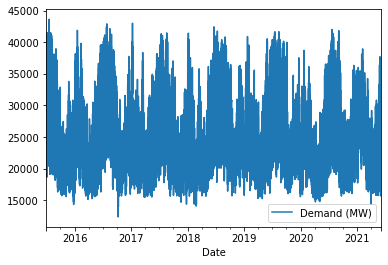

In [11]:
final_demand.plot()

In [12]:
final_demand.isna().sum()

Demand (MW)    0
dtype: int64

### Import Weather Data

In [13]:
# Average weather needs to be approximated across region; using Raleigh for North Carolina and Columbia for South Carolina
# NCEI API Documentation: https://www.ncei.noaa.gov/support/access-data-service-api-user-documentation

today = date.today().strftime("%Y-%m-%d")

ColumbiaSC_ID = '72310013883'
RaleighNC_ID = '72306013722'

ColumbiaSC_url = 'https://www.ncei.noaa.gov/access/services/data/v1?dataset=local-climatological-data&stations=' + ColumbiaSC_ID + '&startDate=2018-07-01&endDate=' + today + '&includeAttributes=true&format=json'
ColumbiaSC_data = requests.get(ColumbiaSC_url).json()
ColumbiaSC_df = pd.DataFrame(ColumbiaSC_data)[['DATE','HourlyDryBulbTemperature']]
print('Columbia, SC Temperatures')
print(ColumbiaSC_df.head())

RaleighNC_url = 'https://www.ncei.noaa.gov/access/services/data/v1?dataset=local-climatological-data&stations=' + RaleighNC_ID + '&startDate=2018-07-01&endDate=' + today + '&includeAttributes=true&format=json'
RaleighNC_data = requests.get(RaleighNC_url).json()
RaleighNC_df = pd.DataFrame(RaleighNC_data)[['DATE','HourlyDryBulbTemperature']]
print('Raleigh, NC Temperatures')
print(RaleighNC_df.head())

Columbia, SC Temperatures
                  DATE HourlyDryBulbTemperature
0  2018-07-01T00:56:00                       78
1  2018-07-01T01:00:00                       78
2  2018-07-01T01:56:00                       77
3  2018-07-01T02:56:00                       77
4  2018-07-01T03:56:00                       76
Raleigh, NC Temperatures
                  DATE HourlyDryBulbTemperature
0  2018-07-01T00:27:00                       77
1  2018-07-01T00:51:00                       78
2  2018-07-01T01:00:00                       78
3  2018-07-01T01:51:00                       77
4  2018-07-01T02:51:00                       76


In [14]:
# Make DATE column the index
ColumbiaSC_df.set_index('DATE', drop=True, inplace=True)
RaleighNC_df.set_index('DATE', drop=True, inplace=True)

In [15]:
# Convert indices to datetime
ColumbiaSC_df.index = pd.to_datetime(ColumbiaSC_df.index)
RaleighNC_df.index = pd.to_datetime(RaleighNC_df.index)

#### Weather Data -- Cleaning

In [16]:
# Find non-numbers in Columbia SC weather
print('Non-numbers in NCEI data')
for index, row in ColumbiaSC_df.iterrows():
    try:
        pd.to_numeric(row)
    except:
        print(index, row['HourlyDryBulbTemperature'])

Non-numbers in NCEI data
2018-07-29 13:54:00 72s
2018-10-23 11:56:00 74s
2018-11-04 12:56:00 68s
2018-11-04 13:00:00 68s
2019-01-27 11:56:00 54s
2019-02-14 13:56:00 66s
2019-06-20 15:42:00 72s
2019-06-20 15:52:00 72s
2019-06-20 16:14:00 72s
2019-06-20 16:40:00 72s
2019-06-20 16:56:00 72s
2019-12-16 14:56:00 74s
2020-03-02 12:56:00 69s
2020-03-02 13:00:00 69s
2020-03-09 13:56:00 72s
2020-12-28 13:56:00 63s
2021-05-03 15:56:00 *


In [17]:
# Find non-numbers in Raleigh NC weather
for index, row in RaleighNC_df.iterrows():
    try:
        pd.to_numeric(row)
    except:
        print(index, row['HourlyDryBulbTemperature'])

2018-08-08 17:58:00 69s
2019-08-21 18:51:00 72s


In [18]:
# Remove 's' tags from temperatures
ColumbiaSC_df.replace('s','', regex=True, inplace=True)
RaleighNC_df.replace('s','', regex=True, inplace=True)

# Replace * rows with np.NaN and fill value
ColumbiaSC_df.replace('*',np.NaN, inplace=True)
RaleighNC_df.replace('*',np.NaN, inplace=True)
ColumbiaSC_df.fillna(method='bfill', inplace=True)
RaleighNC_df.fillna(method='bfill', inplace=True)


# Convert to numeric
ColumbiaSC_df['HourlyDryBulbTemperature'] = pd.to_numeric(ColumbiaSC_df['HourlyDryBulbTemperature'])
RaleighNC_df['HourlyDryBulbTemperature'] = pd.to_numeric(RaleighNC_df['HourlyDryBulbTemperature'])

# Fill missing values with linear interpolation
ColumbiaSC_df = ColumbiaSC_df.interpolate(method='linear')
RaleighNC_df = RaleighNC_df.interpolate(method='linear')

# Resample to 1 hour intervals
ColumbiaSC_df = ColumbiaSC_df.resample('1H').mean()
RaleighNC_df = RaleighNC_df.resample('1H').mean()

ColumbiaSC_df.columns = ['Columbia']
RaleighNC_df.columns = ['Raleigh']

# Merge dataframes on index
temperature_df = pd.merge(ColumbiaSC_df, RaleighNC_df, left_index=True, right_index=True)
temperature_df['Avg_Recorded'] = temperature_df.mean(axis=1)

### Add simulated-day-ahead weather forecast

In [19]:
# Created "simulated" day-ahead forecast from historical weather based on average error in predictions
# MAE of 1.39C from: https://www.mdpi.com/1996-1073/12/7/1309/pdf

day_df = temperature_df.resample('1D').mean()
day_df['Error'] = np.random.normal(0,1.39*(9/5),len(day_df))
daily_error = day_df['Error'].resample('1H').fillna('ffill')
daily_errors = daily_error.iloc[:len(temperature_df)]

In [20]:
# Create "simulated" historical forecast
temperature_df['Sim_1Day_TempForecast'] = temperature_df['Avg_Recorded'] + np.round(daily_errors,2)

# Forward fill few remaining hours from partial day
temperature_df.fillna(method='ffill', inplace=True)
temperature_df.head()

Columbia  Raleigh  Avg_Recorded  Sim_1Day_TempForecast
DATE                                                                       
2018-07-01 00:00:00      78.0     77.5         77.75                  80.51
2018-07-01 01:00:00      77.5     77.5         77.50                  80.26
2018-07-01 02:00:00      77.0     76.0         76.50                  79.26
2018-07-01 03:00:00      76.0     74.0         75.00                  77.76
2018-07-01 04:00:00      76.0     74.0         75.00                  77.76

#### Merge Weather Data with Generation Data

In [21]:
# Add total generation
final_gen['Total_Renewables'] = final_gen.iloc[:,[1,3,6]].sum(axis=1)
final_gen['Total_Generation (MW)'] = final_gen.iloc[:,:7].sum(axis=1)
final_gen.head()

Coal  Hydro  Natural Gas  Nuclear  Other  Petroleum  \
Date                                                                       
2021-06-01 04:00:00  1917    341         4660    11986    591          0   
2021-06-01 03:00:00  2323    946         5600    11979    672          0   
2021-06-01 02:00:00  2707   1959         5713    11980    690          0   
2021-06-01 01:00:00  2871   2031         5837    11973    746         -1   
2021-06-01 00:00:00  3052   1955         5746    11973    735          0   

                     Solar  Total_Renewables  Total_Generation (MW)  
Date                                                                 
2021-06-01 04:00:00     -1             12326                  19494  
2021-06-01 03:00:00     -2             12923                  21518  
2021-06-01 02:00:00     -1             13938                  23048  
2021-06-01 01:00:00     11             14015                  23468  
2021-06-01 00:00:00    415             14343                  23876

In [22]:
# Merge Generation data with temperatures
df_gen = pd.merge(final_gen, temperature_df['Sim_1Day_TempForecast'], left_index=True, right_index=True)

# Reverse Order
df_gen = df_gen.iloc[::-1]
df_gen.tail()

Coal  Hydro  Natural Gas  Nuclear  Other  Petroleum  \
2021-05-30 22:00:00  2165    644         4427    11978    618          0   
2021-05-30 23:00:00  2360    930         4319    11982    613          0   
2021-05-31 00:00:00  2506   1235         4524    11983    608          0   
2021-05-31 01:00:00  2276   1370         4629    11977    650         -1   
2021-05-31 02:00:00  2293   1319         4724    11984    666          0   

                     Solar  Total_Renewables  Total_Generation (MW)  \
2021-05-30 22:00:00   1269             13891                  21101   
2021-05-30 23:00:00   1037             13949                  21241   
2021-05-31 00:00:00    412             13630                  21268   
2021-05-31 01:00:00     11             13358                  20912   
2021-05-31 02:00:00     -2             13301                  20984   

                     Sim_1Day_TempForecast  
2021-05-30 22:00:00                  55.33  
2021-05-30 23:00:00                  55.08  
2021-05-31 00:00:00                  59.70  
2021-05-31 01:00:00                  59.70  
2021-05-31 02:00:00                  59.70

#### Merge Weather Data with Demand Data

In [23]:
# Merge Demand data with temperatures
df = pd.merge(final_demand, temperature_df['Sim_1Day_TempForecast'], left_index=True, right_index=True)

# Reverse Order
df = df.iloc[::-1]
df.tail()

Demand (MW)  Sim_1Day_TempForecast
2021-05-30 22:00:00        21023                  55.33
2021-05-30 23:00:00        21136                  55.08
2021-05-31 00:00:00        21025                  59.70
2021-05-31 01:00:00        20772                  59.70
2021-05-31 02:00:00        20701                  59.70

# Exploratory Data Analysis

### Investigate ACF and PACF of Demand Times Series

In [119]:
# Extract datetime and total generation
X = df.index
y = df.iloc[:,-2]

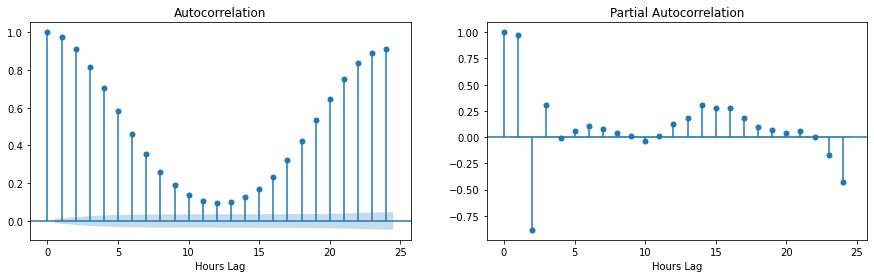

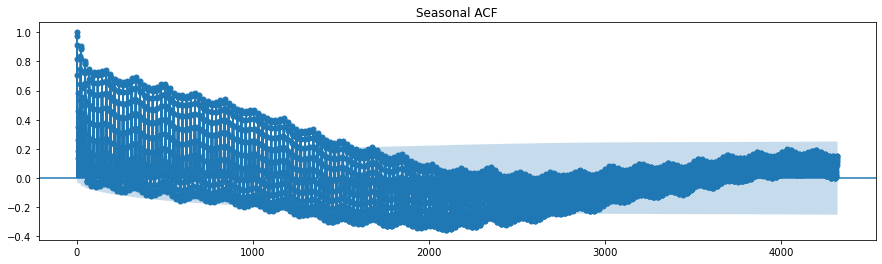

In [26]:
# Graph data
fig, axes = plt.subplots(1, 2, figsize=(15,4))
axes[0].set_xlabel('Hours Lag')
axes[1].set_xlabel('Hours Lag')

fig = sm.graphics.tsaplots.plot_acf(y, lags=24, ax=axes[0])
fig = sm.graphics.tsaplots.plot_pacf(y, lags=24, ax=axes[1])


fig, ax = plt.subplots(figsize=(15,4))
fig = sm.graphics.tsaplots.plot_acf(y, lags=180*24, ax=ax, title='Seasonal ACF')

The ACF plot is in line with expectations. The power consumption during any hour is highly correlated with the previous hour. The power consumption 24 hours away (during the same hour of the next day) is also highly correlated. The lowest correlation is halfway through the day (e.g. temperature at noon poorly predicts temperature at midnight).

The long-term ACF plot shows that the series becomes less correlated with itself as it approaches a lag of around 2000 hours. With 8760 hours per year, this is approximately the time between seasons.

### Correlation Analysis

### Corelations between Generation Sources

In [27]:
gen_sources = df_gen.iloc[:,0:7].drop('Petroleum', axis=1)
gen_sources.tail()

Coal  Hydro  Natural Gas  Nuclear  Other  Solar
2021-05-30 22:00:00  2165    644         4427    11978    618   1269
2021-05-30 23:00:00  2360    930         4319    11982    613   1037
2021-05-31 00:00:00  2506   1235         4524    11983    608    412
2021-05-31 01:00:00  2276   1370         4629    11977    650     11
2021-05-31 02:00:00  2293   1319         4724    11984    666     -2

The Pyplot chart of generation sources shows that Petroleum's contribution is negligible to the total generation capacity and can be ignored. Coal and natural gas have large seasonal swings. Nuclear also shows seasonal swings but stays within a tighter range, providing more of a baseload output. The seasonal trends are harder to see for solar, which are obscured by the strong linear trend of increased capacity over time as well as by daily variations in weather.

Hydro fluctuates between negative and positive capacity. I am not sure what the negative capacity represents, unless it represents being forced to run hydroelectric plants after rainfall at times when there is no demand for additional electricity. The prevalence of occurrence suggests it is not a data error.

In [28]:
gen_sources.corr()

Coal     Hydro  Natural Gas   Nuclear     Other     Solar
Coal         1.000000  0.302808     0.672117  0.177835  0.491352  0.045873
Hydro        0.302808  1.000000     0.466038 -0.005098  0.252307  0.062253
Natural Gas  0.672117  0.466038     1.000000  0.112925  0.655774  0.009659
Nuclear      0.177835 -0.005098     0.112925  1.000000  0.335758 -0.013422
Other        0.491352  0.252307     0.655774  0.335758  1.000000 -0.126180
Solar        0.045873  0.062253     0.009659 -0.013422 -0.126180  1.000000

<AxesSubplot:>

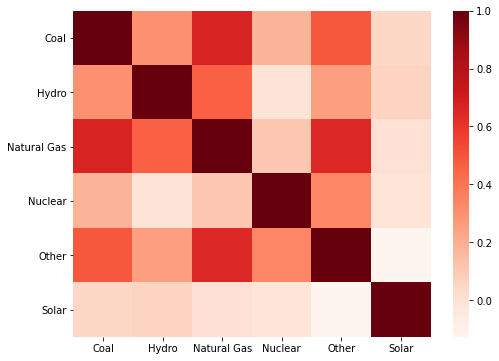

In [29]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(gen_sources.corr(), axes=ax, cmap='Reds')

As inferred from the time series plots, coal and natural gas plant outputs are highly correlated with each other.

### Correlation with Exogenous Variable

In [30]:
gen_temp = df_gen.iloc[:,-2:]
gen_temp.head()

Total_Generation (MW)  Sim_1Day_TempForecast
2018-07-01 05:00:00                  26539                  78.01
2018-07-01 06:00:00                  24971                  80.26
2018-07-01 07:00:00                  23889                  81.76
2018-07-01 08:00:00                  23048                  87.26
2018-07-01 09:00:00                  22493                  90.26

In [31]:
# Correlation coefficient and p-value
scipy.stats.pearsonr(gen_temp.iloc[:,0],gen_temp.iloc[:,1])

(0.16254970371766703, 7.686479124271002e-151)

The correlation between the 1-day temperature forecast and total plant generation is weak but highly significant.

# Pre-Processing and Modeling

## ARIMA -- Autofit AR and MA paramaters

In [32]:
# Silence warnings
import warnings
warnings.filterwarnings('ignore')

# Commented these lines out because it takes too long to run the whole notebook; optimal AR and MA are described below.

#from statsmodels.tsa.arima_process import arma_generate_sample

#best_arma = statsmodels.tsa.stattools.arma_order_select_ic(y, max_ar=5, max_ma=4, ic='bic', trend='c', model_kw=None, fit_kw=None)
#best_arma['bic']

In [33]:
#Plot heatmap of SNS
#sns.heatmap(best_arma['bic'].iloc[1:,1:])
#plt.xlabel('MA')
#plt.ylabel('AR')

An AR of 4 and MA of 3 gives lowest BIC.

### Investigate Integrated Parameter Using KPSS

In [132]:
from statsmodels.tsa.stattools import kpss

# Use kpss()
kpss(y, nlags='auto')

(1.6071593230115961,
 0.01,
 77,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [133]:
kpss(y.diff().dropna(), nlags='auto')

(0.008866217808526521,
 0.1,
 123,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

A single order differentiation removes sufficient trend from the data; the p-value is 0.1 and the null hypothesis that the data is stationary can no longer be rejected. Therefore, use d=1.

## ARIMA Model -- Order (4,1,3)

### 1. Try fitting on all data

In [128]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(y, order=(4,1,3), enforce_stationarity=False)

In [129]:
# Fit ARIMA model
res = model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:            Demand (MW)   No. Observations:                25563
Model:               SARIMAX(4, 1, 3)   Log Likelihood             -193962.676
Date:                Thu, 03 Jun 2021   AIC                         387941.351
Time:                        00:48:34   BIC                         388006.541
Sample:                    07-01-2018   HQIC                        387962.429
                         - 05-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.4501      0.023    106.288      0.000       2.405       2.495
ar.L2         -2.1462      0.049    -43.816      0.000      -2.242      -2.050
ar.L3          0.7681      0.048     15.940      0.0

In [130]:
predict = res.get_prediction(start=0, end=len(y))
predicted_1day = predict.predicted_mean

# Calculate mean absolute percentage error of ARIMA
np.mean(np.abs(predicted_1day - y)/np.abs(y))

0.013267347946748448

In [37]:
sarimax_df = pd.merge(predicted_1day, y, left_index=True, right_index=True)
sarimax_df['SARIMAX_ERROR'] = sarimax_df.iloc[:,-1]-sarimax_df.iloc[:,-2]
sarimax_df.head()

predicted_mean  Demand (MW)  SARIMAX_ERROR
2018-07-01 00:00:00        0.000000        36142   36142.000000
2018-07-01 01:00:00    80418.596569        34552  -45866.596569
2018-07-01 02:00:00    23997.626324        33375    9377.373676
2018-07-01 03:00:00    34453.129118        31136   -3317.129118
2018-07-01 04:00:00    26882.506217        28683    1800.493783

### 2. Split ARIMA into 20 different training sets and make 1-day forecasts

In [38]:
# Address LU decomposition error in SARIMAX
# Suggestion from: https://github.com/statsmodels/statsmodels/issues/5459
#from scipy import linalg
#print(linalg.lapack.dgetrf([np.nan]))
#print(linalg.lapack.dgetrf([np.inf]))

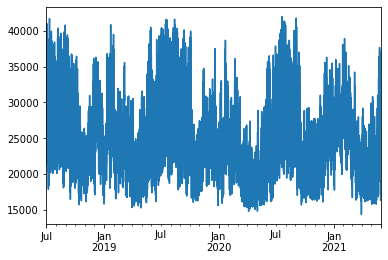

In [39]:
# Quick visual check of data before beginning long loop
y = df.iloc[:,-2].plot()

In [40]:
# Create a loop to test a 24 hour prediction for each time series split

tscv = TimeSeriesSplit(n_splits=20)

# Train-Test Split
X = df.index
y = df.iloc[:,-2]

actuals = []
predictions = []


for train_index, test_index in tqdm(tscv.split(X)):
    y_train, y_test = y[train_index], y[test_index]

    # Define model
    model = SARIMAX(y_train, order=(4,1,3), enforce_stationarity=False)

    # FIt ARIMA model
    res = model.fit()
    
    # Get 24-hour prediction
    predict = res.get_prediction(start=len(y_train), end=len(y_train)+23) # get_prediction includes endpoint, unlike slicing
    predicted_1day = predict.predicted_mean
    
    # Get corresponding actual
    actual = y[len(y_train):len(y_train)+24]
    
    # Append to corresponding lists of actuals versus predictions
    actuals.append(actual)
    predictions.append(predicted_1day)
    
    # Print data to check for issues
    print(actual)
    print(predicted_1day)

1it [00:01,  1.13s/it]

2018-08-20 23:00:00    36405
2018-08-21 00:00:00    35138
2018-08-21 01:00:00    34444
2018-08-21 02:00:00    32558
2018-08-21 03:00:00    29911
2018-08-21 04:00:00    27381
2018-08-21 05:00:00    25282
2018-08-21 06:00:00    23952
2018-08-21 07:00:00    22987
2018-08-21 08:00:00    22397
2018-08-21 09:00:00    22473
2018-08-21 10:00:00    23543
2018-08-21 11:00:00    25526
2018-08-21 12:00:00    26358
2018-08-21 13:00:00    27523
2018-08-21 14:00:00    28800
2018-08-21 15:00:00    30322
2018-08-21 16:00:00    31656
2018-08-21 17:00:00    32801
2018-08-21 18:00:00    33953
2018-08-21 19:00:00    35127
2018-08-21 20:00:00    36063
2018-08-21 21:00:00    36584
2018-08-21 22:00:00    36467
Freq: H, Name: Demand (MW), dtype: int64
2018-08-20 23:00:00    36637.313442
2018-08-21 00:00:00    35538.094574
2018-08-21 01:00:00    34095.547160
2018-08-21 02:00:00    32412.631133
2018-08-21 03:00:00    30611.753576
2018-08-21 04:00:00    28816.630983
2018-08-21 05:00:00    27149.974711
2018-08-21 

2it [00:03,  1.71s/it]

2018-10-10 16:00:00    28292
2018-10-10 17:00:00    29021
2018-10-10 18:00:00    29704
2018-10-10 19:00:00    30208
2018-10-10 20:00:00    30591
2018-10-10 21:00:00    30826
2018-10-10 22:00:00    30561
2018-10-10 23:00:00    30572
2018-10-11 00:00:00    30836
2018-10-11 01:00:00    29970
2018-10-11 02:00:00    28535
2018-10-11 03:00:00    26660
2018-10-11 04:00:00    24903
2018-10-11 05:00:00    23443
2018-10-11 06:00:00    22502
2018-10-11 07:00:00    21940
2018-10-11 08:00:00    21668
2018-10-11 09:00:00    21885
2018-10-11 10:00:00    22887
2018-10-11 11:00:00    24725
2018-10-11 12:00:00    25939
2018-10-11 13:00:00    26712
2018-10-11 14:00:00    27585
2018-10-11 15:00:00    28396
Freq: H, Name: Demand (MW), dtype: int64
2018-10-10 16:00:00    28662.694740
2018-10-10 17:00:00    29814.261517
2018-10-10 18:00:00    30732.029139
2018-10-10 19:00:00    31353.044173
2018-10-10 20:00:00    31644.859332
2018-10-10 21:00:00    31590.913472
2018-10-10 22:00:00    31195.018748
2018-10-10 

3it [00:06,  2.19s/it]

2018-11-30 09:00:00    22902
2018-11-30 10:00:00    23587
2018-11-30 11:00:00    25110
2018-11-30 12:00:00    27666
2018-11-30 13:00:00    28266
2018-11-30 14:00:00    27503
2018-11-30 15:00:00    26131
2018-11-30 16:00:00    25044
2018-11-30 17:00:00    23943
2018-11-30 18:00:00    23057
2018-11-30 19:00:00    22638
2018-11-30 20:00:00    22217
2018-11-30 21:00:00    22171
2018-11-30 22:00:00    22642
2018-11-30 23:00:00    24032
2018-12-01 00:00:00    24544
2018-12-01 01:00:00    24229
2018-12-01 02:00:00    23806
2018-12-01 03:00:00    23128
2018-12-01 04:00:00    21934
2018-12-01 05:00:00    20682
2018-12-01 06:00:00    19655
2018-12-01 07:00:00    18995
2018-12-01 08:00:00    18619
Freq: H, Name: Demand (MW), dtype: int64
2018-11-30 09:00:00    23219.324356
2018-11-30 10:00:00    23965.993963
2018-11-30 11:00:00    24881.541146
2018-11-30 12:00:00    25826.642412
2018-11-30 13:00:00    26712.034636
2018-11-30 14:00:00    27483.056891
2018-11-30 15:00:00    28104.322663
2018-11-30 

4it [00:09,  2.77s/it]

2019-01-20 02:00:00    23535
2019-01-20 03:00:00    22575
2019-01-20 04:00:00    21582
2019-01-20 05:00:00    20367
2019-01-20 06:00:00    19316
2019-01-20 07:00:00    18657
2019-01-20 08:00:00    18164
2019-01-20 09:00:00    17999
2019-01-20 10:00:00    18144
2019-01-20 11:00:00    18721
2019-01-20 12:00:00    19746
2019-01-20 13:00:00    21073
2019-01-20 14:00:00    22438
2019-01-20 15:00:00    23254
2019-01-20 16:00:00    23183
2019-01-20 17:00:00    22859
2019-01-20 18:00:00    22646
2019-01-20 19:00:00    22440
2019-01-20 20:00:00    22253
2019-01-20 21:00:00    22454
2019-01-20 22:00:00    23508
2019-01-20 23:00:00    25840
2019-01-21 00:00:00    28221
2019-01-21 01:00:00    28995
Freq: H, Name: Demand (MW), dtype: int64
2019-01-20 02:00:00    23462.888160
2019-01-20 03:00:00    23016.677228
2019-01-20 04:00:00    22738.681758
2019-01-20 05:00:00    22582.203776
2019-01-20 06:00:00    22511.553099
2019-01-20 07:00:00    22508.275439
2019-01-20 08:00:00    22562.918654
2019-01-20 

5it [00:13,  3.08s/it]

2019-03-11 19:00:00    21758
2019-03-11 20:00:00    21489
2019-03-11 21:00:00    21697
2019-03-11 22:00:00    21926
2019-03-11 23:00:00    22506
2019-03-12 00:00:00    23287
2019-03-12 01:00:00    23661
2019-03-12 02:00:00    22663
2019-03-12 03:00:00    21321
2019-03-12 04:00:00    20046
2019-03-12 05:00:00    19117
2019-03-12 06:00:00    18745
2019-03-12 07:00:00    18793
2019-03-12 08:00:00    19022
2019-03-12 09:00:00    19814
2019-03-12 10:00:00    21704
2019-03-12 11:00:00    24824
2019-03-12 12:00:00    26489
2019-03-12 13:00:00    26060
2019-03-12 14:00:00    24985
2019-03-12 15:00:00    23825
2019-03-12 16:00:00    22714
2019-03-12 17:00:00    21949
2019-03-12 18:00:00    21479
Freq: H, Name: Demand (MW), dtype: int64
2019-03-11 19:00:00    21945.241800
2019-03-11 20:00:00    22062.390540
2019-03-11 21:00:00    22153.620179
2019-03-11 22:00:00    22240.645938
2019-03-11 23:00:00    22316.197390
2019-03-12 00:00:00    22367.109321
2019-03-12 01:00:00    22390.433745
2019-03-12 

6it [00:17,  3.55s/it]

2019-05-01 12:00:00    21522
2019-05-01 13:00:00    22251
2019-05-01 14:00:00    23248
2019-05-01 15:00:00    24398
2019-05-01 16:00:00    25581
2019-05-01 17:00:00    26818
2019-05-01 18:00:00    28207
2019-05-01 19:00:00    29357
2019-05-01 20:00:00    30605
2019-05-01 21:00:00    31259
2019-05-01 22:00:00    31347
2019-05-01 23:00:00    30804
2019-05-02 00:00:00    29679
2019-05-02 01:00:00    29225
2019-05-02 02:00:00    27607
2019-05-02 03:00:00    24964
2019-05-02 04:00:00    22446
2019-05-02 05:00:00    20454
2019-05-02 06:00:00    19225
2019-05-02 07:00:00    18432
2019-05-02 08:00:00    17960
2019-05-02 09:00:00    17981
2019-05-02 10:00:00    18979
2019-05-02 11:00:00    21040
Freq: H, Name: Demand (MW), dtype: int64
2019-05-01 12:00:00    22274.459375
2019-05-01 13:00:00    23885.364910
2019-05-01 14:00:00    25214.918190
2019-05-01 15:00:00    26242.106139
2019-05-01 16:00:00    26926.226045
2019-05-01 17:00:00    27239.242503
2019-05-01 18:00:00    27194.364648
2019-05-01 

7it [00:23,  4.31s/it]

2019-06-21 05:00:00    23275
2019-06-21 06:00:00    21928
2019-06-21 07:00:00    20828
2019-06-21 08:00:00    20211
2019-06-21 09:00:00    20116
2019-06-21 10:00:00    20690
2019-06-21 11:00:00    21865
2019-06-21 12:00:00    23540
2019-06-21 13:00:00    25222
2019-06-21 14:00:00    27044
2019-06-21 15:00:00    28792
2019-06-21 16:00:00    30203
2019-06-21 17:00:00    31480
2019-06-21 18:00:00    32640
2019-06-21 19:00:00    33895
2019-06-21 20:00:00    34836
2019-06-21 21:00:00    35262
2019-06-21 22:00:00    35434
2019-06-21 23:00:00    34562
2019-06-22 00:00:00    33108
2019-06-22 01:00:00    31117
2019-06-22 02:00:00    29601
2019-06-22 03:00:00    27327
2019-06-22 04:00:00    24718
Freq: H, Name: Demand (MW), dtype: int64
2019-06-21 05:00:00    23294.765659
2019-06-21 06:00:00    22125.719342
2019-06-21 07:00:00    21674.458163
2019-06-21 08:00:00    21838.087945
2019-06-21 09:00:00    22525.213765
2019-06-21 10:00:00    23634.725624
2019-06-21 11:00:00    25045.177246
2019-06-21 

8it [00:30,  5.03s/it]

2019-08-10 22:00:00    36780
2019-08-10 23:00:00    36055
2019-08-11 00:00:00    34747
2019-08-11 01:00:00    33562
2019-08-11 02:00:00    32087
2019-08-11 03:00:00    29741
2019-08-11 04:00:00    27505
2019-08-11 05:00:00    25537
2019-08-11 06:00:00    24176
2019-08-11 07:00:00    23128
2019-08-11 08:00:00    22402
2019-08-11 09:00:00    21849
2019-08-11 10:00:00    21712
2019-08-11 11:00:00    21598
2019-08-11 12:00:00    22280
2019-08-11 13:00:00    24157
2019-08-11 14:00:00    26308
2019-08-11 15:00:00    28485
2019-08-11 16:00:00    30525
2019-08-11 17:00:00    32524
2019-08-11 18:00:00    34083
2019-08-11 19:00:00    35327
2019-08-11 20:00:00    36361
2019-08-11 21:00:00    36868
Freq: H, Name: Demand (MW), dtype: int64
2019-08-10 22:00:00    36329.795977
2019-08-10 23:00:00    35775.262983
2019-08-11 00:00:00    34841.829362
2019-08-11 01:00:00    33642.005151
2019-08-11 02:00:00    32292.948517
2019-08-11 03:00:00    30907.245590
2019-08-11 04:00:00    29589.407956
2019-08-11 

9it [00:38,  6.20s/it]

2019-09-30 15:00:00    28594
2019-09-30 16:00:00    30538
2019-09-30 17:00:00    32341
2019-09-30 18:00:00    34470
2019-09-30 19:00:00    35850
2019-09-30 20:00:00    36903
2019-09-30 21:00:00    36798
2019-09-30 22:00:00    36067
2019-09-30 23:00:00    34879
2019-10-01 00:00:00    34189
2019-10-01 01:00:00    32707
2019-10-01 02:00:00    30210
2019-10-01 03:00:00    27535
2019-10-01 04:00:00    25072
2019-10-01 05:00:00    23113
2019-10-01 06:00:00    21950
2019-10-01 07:00:00    21233
2019-10-01 08:00:00    20975
2019-10-01 09:00:00    21089
2019-10-01 10:00:00    22110
2019-10-01 11:00:00    24153
2019-10-01 12:00:00    24997
2019-10-01 13:00:00    25489
2019-10-01 14:00:00    26572
Freq: H, Name: Demand (MW), dtype: int64
2019-09-30 15:00:00    28673.713684
2019-09-30 16:00:00    30487.066372
2019-09-30 17:00:00    32493.189490
2019-09-30 18:00:00    34502.388570
2019-09-30 19:00:00    36274.822817
2019-09-30 20:00:00    37570.967335
2019-09-30 21:00:00    38200.981324
2019-09-30 

10it [00:47,  6.81s/it]

2019-11-20 08:00:00    21810
2019-11-20 09:00:00    22151
2019-11-20 10:00:00    22918
2019-11-20 11:00:00    24663
2019-11-20 12:00:00    27475
2019-11-20 13:00:00    28166
2019-11-20 14:00:00    27058
2019-11-20 15:00:00    25567
2019-11-20 16:00:00    24393
2019-11-20 17:00:00    23544
2019-11-20 18:00:00    22883
2019-11-20 19:00:00    22549
2019-11-20 20:00:00    22394
2019-11-20 21:00:00    22498
2019-11-20 22:00:00    23172
2019-11-20 23:00:00    24783
2019-11-21 00:00:00    25993
2019-11-21 01:00:00    26231
2019-11-21 02:00:00    26168
2019-11-21 03:00:00    25551
2019-11-21 04:00:00    24453
2019-11-21 05:00:00    23718
2019-11-21 06:00:00    23077
2019-11-21 07:00:00    22886
Freq: H, Name: Demand (MW), dtype: int64
2019-11-20 08:00:00    21767.476814
2019-11-20 09:00:00    21858.717045
2019-11-20 10:00:00    22097.807278
2019-11-20 11:00:00    22460.757230
2019-11-20 12:00:00    22918.169912
2019-11-20 13:00:00    23435.630862
2019-11-20 14:00:00    23976.184764
2019-11-20 

11it [00:55,  7.31s/it]

2020-01-10 01:00:00    27598
2020-01-10 02:00:00    27295
2020-01-10 03:00:00    26375
2020-01-10 04:00:00    25041
2020-01-10 05:00:00    23739
2020-01-10 06:00:00    22838
2020-01-10 07:00:00    22647
2020-01-10 08:00:00    22563
2020-01-10 09:00:00    22721
2020-01-10 10:00:00    23270
2020-01-10 11:00:00    24663
2020-01-10 12:00:00    26996
2020-01-10 13:00:00    27838
2020-01-10 14:00:00    27132
2020-01-10 15:00:00    26282
2020-01-10 16:00:00    25227
2020-01-10 17:00:00    24204
2020-01-10 18:00:00    23357
2020-01-10 19:00:00    22794
2020-01-10 20:00:00    22181
2020-01-10 21:00:00    21929
2020-01-10 22:00:00    22237
2020-01-10 23:00:00    23490
2020-01-11 00:00:00    24191
Freq: H, Name: Demand (MW), dtype: int64
2020-01-10 01:00:00    28602.731580
2020-01-10 02:00:00    29564.977942
2020-01-10 03:00:00    30275.881134
2020-01-10 04:00:00    30762.248276
2020-01-10 05:00:00    31012.323387
2020-01-10 06:00:00    31006.725000
2020-01-10 07:00:00    30744.282804
2020-01-10 

12it [01:05,  8.06s/it]

2020-02-29 18:00:00    23780
2020-02-29 19:00:00    22960
2020-02-29 20:00:00    22392
2020-02-29 21:00:00    21998
2020-02-29 22:00:00    22481
2020-02-29 23:00:00    23356
2020-03-01 00:00:00    25312
2020-03-01 01:00:00    26460
2020-03-01 02:00:00    26905
2020-03-01 03:00:00    26956
2020-03-01 04:00:00    26677
2020-03-01 05:00:00    26254
2020-03-01 06:00:00    26118
2020-03-01 07:00:00    26395
2020-03-01 08:00:00    26854
2020-03-01 09:00:00    27548
2020-03-01 10:00:00    28437
2020-03-01 11:00:00    29759
2020-03-01 12:00:00    30892
2020-03-01 13:00:00    31667
2020-03-01 14:00:00    30368
2020-03-01 15:00:00    27615
2020-03-01 16:00:00    25279
2020-03-01 17:00:00    23657
Freq: H, Name: Demand (MW), dtype: int64
2020-02-29 18:00:00    24155.383566
2020-02-29 19:00:00    23665.524941
2020-02-29 20:00:00    23396.254782
2020-02-29 21:00:00    23334.088165
2020-02-29 22:00:00    23461.142021
2020-02-29 23:00:00    23751.408608
2020-03-01 00:00:00    24170.880179
2020-03-01 

13it [01:15,  8.75s/it]

2020-04-20 11:00:00    17650
2020-04-20 12:00:00    18691
2020-04-20 13:00:00    19941
2020-04-20 14:00:00    20784
2020-04-20 15:00:00    21269
2020-04-20 16:00:00    21406
2020-04-20 17:00:00    21327
2020-04-20 18:00:00    21165
2020-04-20 19:00:00    20794
2020-04-20 20:00:00    20707
2020-04-20 21:00:00    20342
2020-04-20 22:00:00    20689
2020-04-20 23:00:00    20887
2020-04-21 00:00:00    20742
2020-04-21 01:00:00    21376
2020-04-21 02:00:00    20579
2020-04-21 03:00:00    19458
2020-04-21 04:00:00    18115
2020-04-21 05:00:00    17178
2020-04-21 06:00:00    16740
2020-04-21 07:00:00    16559
2020-04-21 08:00:00    16585
2020-04-21 09:00:00    16986
2020-04-21 10:00:00    17783
Freq: H, Name: Demand (MW), dtype: int64
2020-04-20 11:00:00    17153.126637
2020-04-20 12:00:00    17934.626446
2020-04-20 13:00:00    18652.063413
2020-04-20 14:00:00    19283.582062
2020-04-20 15:00:00    19801.007786
2020-04-20 16:00:00    20174.478957
2020-04-20 17:00:00    20383.658504
2020-04-20 

14it [01:28, 10.05s/it]

2020-06-10 04:00:00    26564
2020-06-10 05:00:00    24444
2020-06-10 06:00:00    23064
2020-06-10 07:00:00    22189
2020-06-10 08:00:00    21533
2020-06-10 09:00:00    21350
2020-06-10 10:00:00    21969
2020-06-10 11:00:00    22867
2020-06-10 12:00:00    24062
2020-06-10 13:00:00    26038
2020-06-10 14:00:00    28114
2020-06-10 15:00:00    29994
2020-06-10 16:00:00    31790
2020-06-10 17:00:00    33360
2020-06-10 18:00:00    34677
2020-06-10 19:00:00    35341
2020-06-10 20:00:00    35594
2020-06-10 21:00:00    35571
2020-06-10 22:00:00    35183
2020-06-10 23:00:00    34296
2020-06-11 00:00:00    32989
2020-06-11 01:00:00    31623
2020-06-11 02:00:00    30498
2020-06-11 03:00:00    28379
Freq: H, Name: Demand (MW), dtype: int64
2020-06-10 04:00:00    26456.153603
2020-06-10 05:00:00    24223.217140
2020-06-10 06:00:00    22685.166220
2020-06-10 07:00:00    21778.249070
2020-06-10 08:00:00    21399.613273
2020-06-10 09:00:00    21492.957958
2020-06-10 10:00:00    22039.543158
2020-06-10 

15it [01:42, 11.28s/it]

2020-07-30 21:00:00    38436
2020-07-30 22:00:00    38189
2020-07-30 23:00:00    37265
2020-07-31 00:00:00    35605
2020-07-31 01:00:00    34325
2020-07-31 02:00:00    32933
2020-07-31 03:00:00    30512
2020-07-31 04:00:00    28112
2020-07-31 05:00:00    26297
2020-07-31 06:00:00    25028
2020-07-31 07:00:00    24153
2020-07-31 08:00:00    23577
2020-07-31 09:00:00    23493
2020-07-31 10:00:00    24075
2020-07-31 11:00:00    24923
2020-07-31 12:00:00    25917
2020-07-31 13:00:00    27684
2020-07-31 14:00:00    29837
2020-07-31 15:00:00    32244
2020-07-31 16:00:00    34744
2020-07-31 17:00:00    36851
2020-07-31 18:00:00    38620
2020-07-31 19:00:00    39725
2020-07-31 20:00:00    40413
Freq: H, Name: Demand (MW), dtype: int64
2020-07-30 21:00:00    38387.139143
2020-07-30 22:00:00    37855.583892
2020-07-30 23:00:00    36734.979561
2020-07-31 00:00:00    35162.500676
2020-07-31 01:00:00    33288.978970
2020-07-31 02:00:00    31263.241071
2020-07-31 03:00:00    29225.704525
2020-07-31 

16it [01:56, 12.00s/it]

2020-09-19 14:00:00    20020
2020-09-19 15:00:00    20645
2020-09-19 16:00:00    20871
2020-09-19 17:00:00    21034
2020-09-19 18:00:00    21165
2020-09-19 19:00:00    21266
2020-09-19 20:00:00    21182
2020-09-19 21:00:00    21213
2020-09-19 22:00:00    21212
2020-09-19 23:00:00    21025
2020-09-20 00:00:00    21327
2020-09-20 01:00:00    21239
2020-09-20 02:00:00    20390
2020-09-20 03:00:00    19220
2020-09-20 04:00:00    17991
2020-09-20 05:00:00    16984
2020-09-20 06:00:00    16364
2020-09-20 07:00:00    15895
2020-09-20 08:00:00    15652
2020-09-20 09:00:00    15716
2020-09-20 10:00:00    15755
2020-09-20 11:00:00    16309
2020-09-20 12:00:00    16754
2020-09-20 13:00:00    17828
Freq: H, Name: Demand (MW), dtype: int64
2020-09-19 14:00:00    20255.813962
2020-09-19 15:00:00    21487.863266
2020-09-19 16:00:00    22751.371471
2020-09-19 17:00:00    23940.206630
2020-09-19 18:00:00    24965.710297
2020-09-19 19:00:00    25757.634461
2020-09-19 20:00:00    26267.824766
2020-09-19 

17it [02:11, 12.89s/it]

2020-11-09 07:00:00    17069
2020-11-09 08:00:00    16743
2020-11-09 09:00:00    16601
2020-11-09 10:00:00    16881
2020-11-09 11:00:00    17954
2020-11-09 12:00:00    19537
2020-11-09 13:00:00    20526
2020-11-09 14:00:00    21437
2020-11-09 15:00:00    22107
2020-11-09 16:00:00    22766
2020-11-09 17:00:00    23455
2020-11-09 18:00:00    23988
2020-11-09 19:00:00    24404
2020-11-09 20:00:00    24505
2020-11-09 21:00:00    24352
2020-11-09 22:00:00    24256
2020-11-09 23:00:00    25037
2020-11-10 00:00:00    25532
2020-11-10 01:00:00    24806
2020-11-10 02:00:00    23749
2020-11-10 03:00:00    22391
2020-11-10 04:00:00    20861
2020-11-10 05:00:00    19332
2020-11-10 06:00:00    18276
Freq: H, Name: Demand (MW), dtype: int64
2020-11-09 07:00:00    17011.351365
2020-11-09 08:00:00    16579.298262
2020-11-09 09:00:00    16416.791716
2020-11-09 10:00:00    16511.299554
2020-11-09 11:00:00    16835.061000
2020-11-09 12:00:00    17347.993521
2020-11-09 13:00:00    18000.607319
2020-11-09 

18it [02:26, 13.40s/it]

2020-12-30 00:00:00    27133
2020-12-30 01:00:00    27330
2020-12-30 02:00:00    27296
2020-12-30 03:00:00    26840
2020-12-30 04:00:00    25884
2020-12-30 05:00:00    25064
2020-12-30 06:00:00    24494
2020-12-30 07:00:00    24449
2020-12-30 08:00:00    24520
2020-12-30 09:00:00    25025
2020-12-30 10:00:00    26050
2020-12-30 11:00:00    27412
2020-12-30 12:00:00    29323
2020-12-30 13:00:00    30602
2020-12-30 14:00:00    30707
2020-12-30 15:00:00    29824
2020-12-30 16:00:00    28882
2020-12-30 17:00:00    28031
2020-12-30 18:00:00    27319
2020-12-30 19:00:00    26936
2020-12-30 20:00:00    26504
2020-12-30 21:00:00    26421
2020-12-30 22:00:00    26811
2020-12-30 23:00:00    28244
Freq: H, Name: Demand (MW), dtype: int64
2020-12-30 00:00:00    27967.076621
2020-12-30 01:00:00    29866.399191
2020-12-30 02:00:00    31296.658364
2020-12-30 03:00:00    32331.763959
2020-12-30 04:00:00    32962.364217
2020-12-30 05:00:00    33151.721406
2020-12-30 06:00:00    32902.152588
2020-12-30 

19it [02:43, 14.59s/it]

2021-02-18 17:00:00    33347
2021-02-18 18:00:00    32829
2021-02-18 19:00:00    32626
2021-02-18 20:00:00    31986
2021-02-18 21:00:00    31716
2021-02-18 22:00:00    31784
2021-02-18 23:00:00    32421
2021-02-19 00:00:00    33183
2021-02-19 01:00:00    32737
2021-02-19 02:00:00    32023
2021-02-19 03:00:00    30849
2021-02-19 04:00:00    29395
2021-02-19 05:00:00    28130
2021-02-19 06:00:00    27331
2021-02-19 07:00:00    27018
2021-02-19 08:00:00    26871
2021-02-19 09:00:00    27013
2021-02-19 10:00:00    27755
2021-02-19 11:00:00    29268
2021-02-19 12:00:00    31166
2021-02-19 13:00:00    32594
2021-02-19 14:00:00    32955
2021-02-19 15:00:00    32577
2021-02-19 16:00:00    31775
Freq: H, Name: Demand (MW), dtype: int64
2021-02-18 17:00:00    33240.710399
2021-02-18 18:00:00    32660.608525
2021-02-18 19:00:00    31808.008001
2021-02-18 20:00:00    30795.808616
2021-02-18 21:00:00    29725.143330
2021-02-18 22:00:00    28683.358291
2021-02-18 23:00:00    27747.970901
2021-02-19 

20it [03:00,  9.00s/it]

2021-04-10 10:00:00    16762
2021-04-10 11:00:00    17240
2021-04-10 12:00:00    17772
2021-04-10 13:00:00    18927
2021-04-10 14:00:00    20019
2021-04-10 15:00:00    20874
2021-04-10 16:00:00    21633
2021-04-10 17:00:00    22212
2021-04-10 18:00:00    22651
2021-04-10 19:00:00    22843
2021-04-10 20:00:00    22961
2021-04-10 21:00:00    22962
2021-04-10 22:00:00    22964
2021-04-10 23:00:00    22783
2021-04-11 00:00:00    22694
2021-04-11 01:00:00    22816
2021-04-11 02:00:00    22012
2021-04-11 03:00:00    20844
2021-04-11 04:00:00    19453
2021-04-11 05:00:00    18156
2021-04-11 06:00:00    17292
2021-04-11 07:00:00    16666
2021-04-11 08:00:00    16294
2021-04-11 09:00:00    16121
Freq: H, Name: Demand (MW), dtype: int64
2021-04-10 10:00:00    16588.875259
2021-04-10 11:00:00    17196.509377
2021-04-10 12:00:00    18085.578937
2021-04-10 13:00:00    19162.611987
2021-04-10 14:00:00    20330.081883
2021-04-10 15:00:00    21496.361960
2021-04-10 16:00:00    22578.181866
2021-04-10 

In [41]:
# flatten lists
actuals = [item for sublist in actuals for item in sublist]
predictions = [item for sublist in predictions for item in sublist]

In [42]:
# Combine flattened lists into DataFrame
compare = pd.DataFrame({'Predictions': predictions, 'Actuals': actuals})

Text(0.5, 0, 'Discontinuous time (in chunks used for cross-val)')

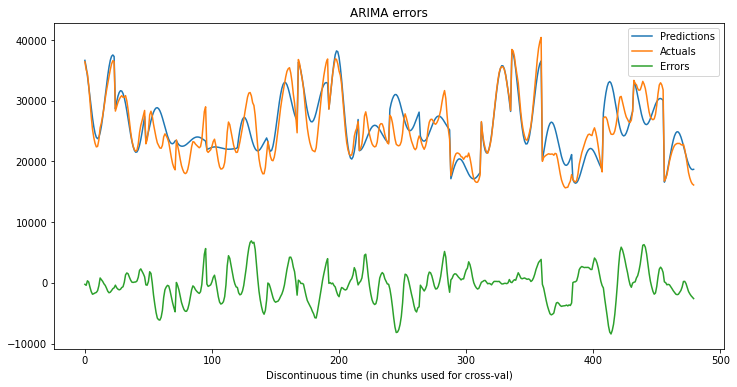

In [43]:
# Add errros
compare['Errors'] = compare['Actuals'] - compare['Predictions']
compare.plot(figsize=(12,6))
plt.title('ARIMA errors')
plt.xlabel('Discontinuous time (in chunks used for cross-val)')

In [44]:
# Calculate MAPE
np.mean(np.abs(compare['Errors'])/compare['Actuals'])

0.08363699443588107

## ARIMA with Exogenous Variable (1-Day Temperature Forecast)

In [45]:
# Create df with exogenous variable
exog_df = pd.merge(y, temperature_df['Sim_1Day_TempForecast'], left_index=True, right_index=True)

In [46]:
y = exog_df.iloc[:,-2]
exog = exog_df.iloc[:,-1]
model2 = SARIMAX(y, exog, order=(4,1,3))
res2 = model2.fit(disp=False)
print(res2.summary())

                               SARIMAX Results                                
Dep. Variable:            Demand (MW)   No. Observations:                25563
Model:               SARIMAX(4, 1, 3)   Log Likelihood             -192913.084
Date:                Wed, 02 Jun 2021   AIC                         385844.167
Time:                        06:40:06   BIC                         385917.507
Sample:                    07-01-2018   HQIC                        385867.880
                         - 05-31-2021                                         
Covariance Type:                  opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Sim_1Day_TempForecast    29.9118      1.705     17.549      0.000      26.571      33.253
ar.L1                     3.5050      0.004    886.592      0.000       3.497       3.513
ar.L2   

### 2. Split ARIMAX (with weather) into 20 different training sets and make 1-day forecasts

In [47]:
# Address LU decomposition error in SARIMAX
# Suggestion from: https://github.com/statsmodels/statsmodels/issues/5459
#from scipy import linalg
#print(linalg.lapack.dgetrf([np.nan]))
#print(linalg.lapack.dgetrf([np.inf]))

In [48]:
# Create a loop to test a 24 hour prediction for each time series split

tscv = TimeSeriesSplit(n_splits=20)

actuals = []
predictions = []

In [49]:
exog_df.head()

Demand (MW)  Sim_1Day_TempForecast
2018-07-01 00:00:00        36142                  80.51
2018-07-01 01:00:00        34552                  80.26
2018-07-01 02:00:00        33375                  79.26
2018-07-01 03:00:00        31136                  77.76
2018-07-01 04:00:00        28683                  77.76

In [50]:
for train_index, test_index in tqdm(tscv.split(X)):
    exog_train, exog_test = exog_df.iloc[train_index,:], exog_df.iloc[test_index,:]
    y_train = exog_train.iloc[:,-2]
    y_test = exog_test.iloc[:,-2]
    weather_train = exog_train.iloc[:,-1]
    weather_test = exog_test.iloc[:,-1]

    # Define model
    model = SARIMAX(y_train, exog=weather_train, order=(4,1,3), enforce_stationarity=False)

    # FIt ARIMAX model
    res = model.fit()
    
    # Get 24-hour prediction
    predict = res.get_prediction(start=len(y_train), end=len(y_train)+23, exog=weather_test[:24]) # get_prediction includes endpoint, unlike slicing
    predicted_1day = predict.predicted_mean
    
    # Get corresponding actual
    actual = y[len(y_train):len(y_train)+24]
    
    # Append to corresponding lists of actuals versus predictions
    actuals.append(actual)
    predictions.append(predicted_1day)
    
    # Print data to check for issues
    print(actual)
    print(predicted_1day)

1it [00:03,  3.01s/it]

2018-08-20 23:00:00    36405
2018-08-21 00:00:00    35138
2018-08-21 01:00:00    34444
2018-08-21 02:00:00    32558
2018-08-21 03:00:00    29911
2018-08-21 04:00:00    27381
2018-08-21 05:00:00    25282
2018-08-21 06:00:00    23952
2018-08-21 07:00:00    22987
2018-08-21 08:00:00    22397
2018-08-21 09:00:00    22473
2018-08-21 10:00:00    23543
2018-08-21 11:00:00    25526
2018-08-21 12:00:00    26358
2018-08-21 13:00:00    27523
2018-08-21 14:00:00    28800
2018-08-21 15:00:00    30322
2018-08-21 16:00:00    31656
2018-08-21 17:00:00    32801
2018-08-21 18:00:00    33953
2018-08-21 19:00:00    35127
2018-08-21 20:00:00    36063
2018-08-21 21:00:00    36584
2018-08-21 22:00:00    36467
Freq: H, Name: Demand (MW), dtype: int64
2018-08-20 23:00:00    36446.517724
2018-08-21 00:00:00    35952.398150
2018-08-21 01:00:00    34272.434499
2018-08-21 02:00:00    32332.901482
2018-08-21 03:00:00    30337.981829
2018-08-21 04:00:00    28446.468955
2018-08-21 05:00:00    26763.146491
2018-08-21 

2it [00:07,  3.85s/it]

2018-10-10 16:00:00    28292
2018-10-10 17:00:00    29021
2018-10-10 18:00:00    29704
2018-10-10 19:00:00    30208
2018-10-10 20:00:00    30591
2018-10-10 21:00:00    30826
2018-10-10 22:00:00    30561
2018-10-10 23:00:00    30572
2018-10-11 00:00:00    30836
2018-10-11 01:00:00    29970
2018-10-11 02:00:00    28535
2018-10-11 03:00:00    26660
2018-10-11 04:00:00    24903
2018-10-11 05:00:00    23443
2018-10-11 06:00:00    22502
2018-10-11 07:00:00    21940
2018-10-11 08:00:00    21668
2018-10-11 09:00:00    21885
2018-10-11 10:00:00    22887
2018-10-11 11:00:00    24725
2018-10-11 12:00:00    25939
2018-10-11 13:00:00    26712
2018-10-11 14:00:00    27585
2018-10-11 15:00:00    28396
Freq: H, Name: Demand (MW), dtype: int64
2018-10-10 16:00:00    28607.502140
2018-10-10 17:00:00    29704.719664
2018-10-10 18:00:00    30564.389480
2018-10-10 19:00:00    31191.015787
2018-10-10 20:00:00    31496.548365
2018-10-10 21:00:00    31360.964234
2018-10-10 22:00:00    30897.998474
2018-10-10 

3it [00:14,  5.30s/it]

2018-11-30 09:00:00    22902
2018-11-30 10:00:00    23587
2018-11-30 11:00:00    25110
2018-11-30 12:00:00    27666
2018-11-30 13:00:00    28266
2018-11-30 14:00:00    27503
2018-11-30 15:00:00    26131
2018-11-30 16:00:00    25044
2018-11-30 17:00:00    23943
2018-11-30 18:00:00    23057
2018-11-30 19:00:00    22638
2018-11-30 20:00:00    22217
2018-11-30 21:00:00    22171
2018-11-30 22:00:00    22642
2018-11-30 23:00:00    24032
2018-12-01 00:00:00    24544
2018-12-01 01:00:00    24229
2018-12-01 02:00:00    23806
2018-12-01 03:00:00    23128
2018-12-01 04:00:00    21934
2018-12-01 05:00:00    20682
2018-12-01 06:00:00    19655
2018-12-01 07:00:00    18995
2018-12-01 08:00:00    18619
Freq: H, Name: Demand (MW), dtype: int64
2018-11-30 09:00:00    23084.164750
2018-11-30 10:00:00    23638.658356
2018-11-30 11:00:00    24338.009219
2018-11-30 12:00:00    25043.114292
2018-11-30 13:00:00    25724.386598
2018-11-30 14:00:00    26321.133623
2018-11-30 15:00:00    26774.080677
2018-11-30 

4it [00:22,  6.46s/it]

2019-01-20 02:00:00    23535
2019-01-20 03:00:00    22575
2019-01-20 04:00:00    21582
2019-01-20 05:00:00    20367
2019-01-20 06:00:00    19316
2019-01-20 07:00:00    18657
2019-01-20 08:00:00    18164
2019-01-20 09:00:00    17999
2019-01-20 10:00:00    18144
2019-01-20 11:00:00    18721
2019-01-20 12:00:00    19746
2019-01-20 13:00:00    21073
2019-01-20 14:00:00    22438
2019-01-20 15:00:00    23254
2019-01-20 16:00:00    23183
2019-01-20 17:00:00    22859
2019-01-20 18:00:00    22646
2019-01-20 19:00:00    22440
2019-01-20 20:00:00    22253
2019-01-20 21:00:00    22454
2019-01-20 22:00:00    23508
2019-01-20 23:00:00    25840
2019-01-21 00:00:00    28221
2019-01-21 01:00:00    28995
Freq: H, Name: Demand (MW), dtype: int64
2019-01-20 02:00:00    23591.282008
2019-01-20 03:00:00    23347.599194
2019-01-20 04:00:00    23298.853053
2019-01-20 05:00:00    23314.965892
2019-01-20 06:00:00    23330.749159
2019-01-20 07:00:00    23438.238246
2019-01-20 08:00:00    23594.968498
2019-01-20 

5it [00:34,  8.24s/it]

2019-03-11 19:00:00    21758
2019-03-11 20:00:00    21489
2019-03-11 21:00:00    21697
2019-03-11 22:00:00    21926
2019-03-11 23:00:00    22506
2019-03-12 00:00:00    23287
2019-03-12 01:00:00    23661
2019-03-12 02:00:00    22663
2019-03-12 03:00:00    21321
2019-03-12 04:00:00    20046
2019-03-12 05:00:00    19117
2019-03-12 06:00:00    18745
2019-03-12 07:00:00    18793
2019-03-12 08:00:00    19022
2019-03-12 09:00:00    19814
2019-03-12 10:00:00    21704
2019-03-12 11:00:00    24824
2019-03-12 12:00:00    26489
2019-03-12 13:00:00    26060
2019-03-12 14:00:00    24985
2019-03-12 15:00:00    23825
2019-03-12 16:00:00    22714
2019-03-12 17:00:00    21949
2019-03-12 18:00:00    21479
Freq: H, Name: Demand (MW), dtype: int64
2019-03-11 19:00:00    22013.854316
2019-03-11 20:00:00    22032.246472
2019-03-11 21:00:00    21907.117550
2019-03-11 22:00:00    21656.497784
2019-03-11 23:00:00    21226.146115
2019-03-12 00:00:00    20752.498397
2019-03-12 01:00:00    20226.233009
2019-03-12 

6it [00:48, 10.46s/it]

2019-05-01 12:00:00    21522
2019-05-01 13:00:00    22251
2019-05-01 14:00:00    23248
2019-05-01 15:00:00    24398
2019-05-01 16:00:00    25581
2019-05-01 17:00:00    26818
2019-05-01 18:00:00    28207
2019-05-01 19:00:00    29357
2019-05-01 20:00:00    30605
2019-05-01 21:00:00    31259
2019-05-01 22:00:00    31347
2019-05-01 23:00:00    30804
2019-05-02 00:00:00    29679
2019-05-02 01:00:00    29225
2019-05-02 02:00:00    27607
2019-05-02 03:00:00    24964
2019-05-02 04:00:00    22446
2019-05-02 05:00:00    20454
2019-05-02 06:00:00    19225
2019-05-02 07:00:00    18432
2019-05-02 08:00:00    17960
2019-05-02 09:00:00    17981
2019-05-02 10:00:00    18979
2019-05-02 11:00:00    21040
Freq: H, Name: Demand (MW), dtype: int64
2019-05-01 12:00:00    22291.832224
2019-05-01 13:00:00    23902.425460
2019-05-01 14:00:00    25338.469176
2019-05-01 15:00:00    26463.006712
2019-05-01 16:00:00    27266.676325
2019-05-01 17:00:00    27773.464537
2019-05-01 18:00:00    27893.582435
2019-05-01 

7it [01:05, 12.51s/it]

2019-06-21 05:00:00    23275
2019-06-21 06:00:00    21928
2019-06-21 07:00:00    20828
2019-06-21 08:00:00    20211
2019-06-21 09:00:00    20116
2019-06-21 10:00:00    20690
2019-06-21 11:00:00    21865
2019-06-21 12:00:00    23540
2019-06-21 13:00:00    25222
2019-06-21 14:00:00    27044
2019-06-21 15:00:00    28792
2019-06-21 16:00:00    30203
2019-06-21 17:00:00    31480
2019-06-21 18:00:00    32640
2019-06-21 19:00:00    33895
2019-06-21 20:00:00    34836
2019-06-21 21:00:00    35262
2019-06-21 22:00:00    35434
2019-06-21 23:00:00    34562
2019-06-22 00:00:00    33108
2019-06-22 01:00:00    31117
2019-06-22 02:00:00    29601
2019-06-22 03:00:00    27327
2019-06-22 04:00:00    24718
Freq: H, Name: Demand (MW), dtype: int64
2019-06-21 05:00:00    23338.692446
2019-06-21 06:00:00    22328.728685
2019-06-21 07:00:00    21981.277550
2019-06-21 08:00:00    22319.150622
2019-06-21 09:00:00    23036.961134
2019-06-21 10:00:00    24109.413124
2019-06-21 11:00:00    25501.099166
2019-06-21 

8it [01:25, 14.75s/it]

2019-08-10 22:00:00    36780
2019-08-10 23:00:00    36055
2019-08-11 00:00:00    34747
2019-08-11 01:00:00    33562
2019-08-11 02:00:00    32087
2019-08-11 03:00:00    29741
2019-08-11 04:00:00    27505
2019-08-11 05:00:00    25537
2019-08-11 06:00:00    24176
2019-08-11 07:00:00    23128
2019-08-11 08:00:00    22402
2019-08-11 09:00:00    21849
2019-08-11 10:00:00    21712
2019-08-11 11:00:00    21598
2019-08-11 12:00:00    22280
2019-08-11 13:00:00    24157
2019-08-11 14:00:00    26308
2019-08-11 15:00:00    28485
2019-08-11 16:00:00    30525
2019-08-11 17:00:00    32524
2019-08-11 18:00:00    34083
2019-08-11 19:00:00    35327
2019-08-11 20:00:00    36361
2019-08-11 21:00:00    36868
Freq: H, Name: Demand (MW), dtype: int64
2019-08-10 22:00:00    36391.745386
2019-08-10 23:00:00    35937.899753
2019-08-11 00:00:00    35143.387883
2019-08-11 01:00:00    33982.186699
2019-08-11 02:00:00    32553.318848
2019-08-11 03:00:00    30990.996960
2019-08-11 04:00:00    29376.130059
2019-08-11 

9it [01:46, 16.90s/it]

2019-09-30 15:00:00    28594
2019-09-30 16:00:00    30538
2019-09-30 17:00:00    32341
2019-09-30 18:00:00    34470
2019-09-30 19:00:00    35850
2019-09-30 20:00:00    36903
2019-09-30 21:00:00    36798
2019-09-30 22:00:00    36067
2019-09-30 23:00:00    34879
2019-10-01 00:00:00    34189
2019-10-01 01:00:00    32707
2019-10-01 02:00:00    30210
2019-10-01 03:00:00    27535
2019-10-01 04:00:00    25072
2019-10-01 05:00:00    23113
2019-10-01 06:00:00    21950
2019-10-01 07:00:00    21233
2019-10-01 08:00:00    20975
2019-10-01 09:00:00    21089
2019-10-01 10:00:00    22110
2019-10-01 11:00:00    24153
2019-10-01 12:00:00    24997
2019-10-01 13:00:00    25489
2019-10-01 14:00:00    26572
Freq: H, Name: Demand (MW), dtype: int64
2019-09-30 15:00:00    28718.455495
2019-09-30 16:00:00    30401.502836
2019-09-30 17:00:00    32039.834803
2019-09-30 18:00:00    33515.263847
2019-09-30 19:00:00    34697.238528
2019-09-30 20:00:00    35477.273381
2019-09-30 21:00:00    35841.465262
2019-09-30 

10it [02:12, 19.50s/it]

2019-11-20 08:00:00    21810
2019-11-20 09:00:00    22151
2019-11-20 10:00:00    22918
2019-11-20 11:00:00    24663
2019-11-20 12:00:00    27475
2019-11-20 13:00:00    28166
2019-11-20 14:00:00    27058
2019-11-20 15:00:00    25567
2019-11-20 16:00:00    24393
2019-11-20 17:00:00    23544
2019-11-20 18:00:00    22883
2019-11-20 19:00:00    22549
2019-11-20 20:00:00    22394
2019-11-20 21:00:00    22498
2019-11-20 22:00:00    23172
2019-11-20 23:00:00    24783
2019-11-21 00:00:00    25993
2019-11-21 01:00:00    26231
2019-11-21 02:00:00    26168
2019-11-21 03:00:00    25551
2019-11-21 04:00:00    24453
2019-11-21 05:00:00    23718
2019-11-21 06:00:00    23077
2019-11-21 07:00:00    22886
Freq: H, Name: Demand (MW), dtype: int64
2019-11-20 08:00:00    21734.978166
2019-11-20 09:00:00    21695.988380
2019-11-20 10:00:00    21709.796035
2019-11-20 11:00:00    21832.054438
2019-11-20 12:00:00    22070.914319
2019-11-20 13:00:00    22404.123883
2019-11-20 14:00:00    22817.499465
2019-11-20 

11it [02:51, 25.46s/it]

2020-01-10 01:00:00    27598
2020-01-10 02:00:00    27295
2020-01-10 03:00:00    26375
2020-01-10 04:00:00    25041
2020-01-10 05:00:00    23739
2020-01-10 06:00:00    22838
2020-01-10 07:00:00    22647
2020-01-10 08:00:00    22563
2020-01-10 09:00:00    22721
2020-01-10 10:00:00    23270
2020-01-10 11:00:00    24663
2020-01-10 12:00:00    26996
2020-01-10 13:00:00    27838
2020-01-10 14:00:00    27132
2020-01-10 15:00:00    26282
2020-01-10 16:00:00    25227
2020-01-10 17:00:00    24204
2020-01-10 18:00:00    23357
2020-01-10 19:00:00    22794
2020-01-10 20:00:00    22181
2020-01-10 21:00:00    21929
2020-01-10 22:00:00    22237
2020-01-10 23:00:00    23490
2020-01-11 00:00:00    24191
Freq: H, Name: Demand (MW), dtype: int64
2020-01-10 01:00:00    28278.030860
2020-01-10 02:00:00    28927.545399
2020-01-10 03:00:00    29355.460563
2020-01-10 04:00:00    29602.208303
2020-01-10 05:00:00    29716.733523
2020-01-10 06:00:00    29685.223789
2020-01-10 07:00:00    29537.936502
2020-01-10 

12it [03:22, 27.41s/it]

2020-02-29 18:00:00    23780
2020-02-29 19:00:00    22960
2020-02-29 20:00:00    22392
2020-02-29 21:00:00    21998
2020-02-29 22:00:00    22481
2020-02-29 23:00:00    23356
2020-03-01 00:00:00    25312
2020-03-01 01:00:00    26460
2020-03-01 02:00:00    26905
2020-03-01 03:00:00    26956
2020-03-01 04:00:00    26677
2020-03-01 05:00:00    26254
2020-03-01 06:00:00    26118
2020-03-01 07:00:00    26395
2020-03-01 08:00:00    26854
2020-03-01 09:00:00    27548
2020-03-01 10:00:00    28437
2020-03-01 11:00:00    29759
2020-03-01 12:00:00    30892
2020-03-01 13:00:00    31667
2020-03-01 14:00:00    30368
2020-03-01 15:00:00    27615
2020-03-01 16:00:00    25279
2020-03-01 17:00:00    23657
Freq: H, Name: Demand (MW), dtype: int64
2020-02-29 18:00:00    24045.115122
2020-02-29 19:00:00    23439.998717
2020-02-29 20:00:00    22862.950245
2020-02-29 21:00:00    22610.001985
2020-02-29 22:00:00    22344.669239
2020-02-29 23:00:00    22325.716898
2020-03-01 00:00:00    22538.762261
2020-03-01 

13it [03:55, 29.08s/it]

2020-04-20 11:00:00    17650
2020-04-20 12:00:00    18691
2020-04-20 13:00:00    19941
2020-04-20 14:00:00    20784
2020-04-20 15:00:00    21269
2020-04-20 16:00:00    21406
2020-04-20 17:00:00    21327
2020-04-20 18:00:00    21165
2020-04-20 19:00:00    20794
2020-04-20 20:00:00    20707
2020-04-20 21:00:00    20342
2020-04-20 22:00:00    20689
2020-04-20 23:00:00    20887
2020-04-21 00:00:00    20742
2020-04-21 01:00:00    21376
2020-04-21 02:00:00    20579
2020-04-21 03:00:00    19458
2020-04-21 04:00:00    18115
2020-04-21 05:00:00    17178
2020-04-21 06:00:00    16740
2020-04-21 07:00:00    16559
2020-04-21 08:00:00    16585
2020-04-21 09:00:00    16986
2020-04-21 10:00:00    17783
Freq: H, Name: Demand (MW), dtype: int64
2020-04-20 11:00:00    17171.192754
2020-04-20 12:00:00    17902.303614
2020-04-20 13:00:00    18490.849900
2020-04-20 14:00:00    19042.804587
2020-04-20 15:00:00    19479.468409
2020-04-20 16:00:00    19768.912171
2020-04-20 17:00:00    19897.305984
2020-04-20 

14it [04:35, 32.13s/it]

2020-06-10 04:00:00    26564
2020-06-10 05:00:00    24444
2020-06-10 06:00:00    23064
2020-06-10 07:00:00    22189
2020-06-10 08:00:00    21533
2020-06-10 09:00:00    21350
2020-06-10 10:00:00    21969
2020-06-10 11:00:00    22867
2020-06-10 12:00:00    24062
2020-06-10 13:00:00    26038
2020-06-10 14:00:00    28114
2020-06-10 15:00:00    29994
2020-06-10 16:00:00    31790
2020-06-10 17:00:00    33360
2020-06-10 18:00:00    34677
2020-06-10 19:00:00    35341
2020-06-10 20:00:00    35594
2020-06-10 21:00:00    35571
2020-06-10 22:00:00    35183
2020-06-10 23:00:00    34296
2020-06-11 00:00:00    32989
2020-06-11 01:00:00    31623
2020-06-11 02:00:00    30498
2020-06-11 03:00:00    28379
Freq: H, Name: Demand (MW), dtype: int64
2020-06-10 04:00:00    26591.906268
2020-06-10 05:00:00    24461.745822
2020-06-10 06:00:00    22902.879643
2020-06-10 07:00:00    21916.937872
2020-06-10 08:00:00    21582.630810
2020-06-10 09:00:00    21747.819244
2020-06-10 10:00:00    22439.803920
2020-06-10 

15it [05:11, 33.31s/it]

2020-07-30 21:00:00    38436
2020-07-30 22:00:00    38189
2020-07-30 23:00:00    37265
2020-07-31 00:00:00    35605
2020-07-31 01:00:00    34325
2020-07-31 02:00:00    32933
2020-07-31 03:00:00    30512
2020-07-31 04:00:00    28112
2020-07-31 05:00:00    26297
2020-07-31 06:00:00    25028
2020-07-31 07:00:00    24153
2020-07-31 08:00:00    23577
2020-07-31 09:00:00    23493
2020-07-31 10:00:00    24075
2020-07-31 11:00:00    24923
2020-07-31 12:00:00    25917
2020-07-31 13:00:00    27684
2020-07-31 14:00:00    29837
2020-07-31 15:00:00    32244
2020-07-31 16:00:00    34744
2020-07-31 17:00:00    36851
2020-07-31 18:00:00    38620
2020-07-31 19:00:00    39725
2020-07-31 20:00:00    40413
Freq: H, Name: Demand (MW), dtype: int64
2020-07-30 21:00:00    38365.058854
2020-07-30 22:00:00    37804.897117
2020-07-30 23:00:00    36657.747642
2020-07-31 00:00:00    35164.699864
2020-07-31 01:00:00    33284.435192
2020-07-31 02:00:00    31246.040506
2020-07-31 03:00:00    29201.310414
2020-07-31 

16it [05:47, 34.17s/it]

2020-09-19 14:00:00    20020
2020-09-19 15:00:00    20645
2020-09-19 16:00:00    20871
2020-09-19 17:00:00    21034
2020-09-19 18:00:00    21165
2020-09-19 19:00:00    21266
2020-09-19 20:00:00    21182
2020-09-19 21:00:00    21213
2020-09-19 22:00:00    21212
2020-09-19 23:00:00    21025
2020-09-20 00:00:00    21327
2020-09-20 01:00:00    21239
2020-09-20 02:00:00    20390
2020-09-20 03:00:00    19220
2020-09-20 04:00:00    17991
2020-09-20 05:00:00    16984
2020-09-20 06:00:00    16364
2020-09-20 07:00:00    15895
2020-09-20 08:00:00    15652
2020-09-20 09:00:00    15716
2020-09-20 10:00:00    15755
2020-09-20 11:00:00    16309
2020-09-20 12:00:00    16754
2020-09-20 13:00:00    17828
Freq: H, Name: Demand (MW), dtype: int64
2020-09-19 14:00:00    20345.630595
2020-09-19 15:00:00    21673.426843
2020-09-19 16:00:00    23000.288463
2020-09-19 17:00:00    24211.928941
2020-09-19 18:00:00    25204.414982
2020-09-19 19:00:00    25941.545207
2020-09-19 20:00:00    26337.521965
2020-09-19 

17it [06:31, 37.06s/it]

2020-11-09 07:00:00    17069
2020-11-09 08:00:00    16743
2020-11-09 09:00:00    16601
2020-11-09 10:00:00    16881
2020-11-09 11:00:00    17954
2020-11-09 12:00:00    19537
2020-11-09 13:00:00    20526
2020-11-09 14:00:00    21437
2020-11-09 15:00:00    22107
2020-11-09 16:00:00    22766
2020-11-09 17:00:00    23455
2020-11-09 18:00:00    23988
2020-11-09 19:00:00    24404
2020-11-09 20:00:00    24505
2020-11-09 21:00:00    24352
2020-11-09 22:00:00    24256
2020-11-09 23:00:00    25037
2020-11-10 00:00:00    25532
2020-11-10 01:00:00    24806
2020-11-10 02:00:00    23749
2020-11-10 03:00:00    22391
2020-11-10 04:00:00    20861
2020-11-10 05:00:00    19332
2020-11-10 06:00:00    18276
Freq: H, Name: Demand (MW), dtype: int64
2020-11-09 07:00:00    17017.067795
2020-11-09 08:00:00    16640.232365
2020-11-09 09:00:00    16464.096098
2020-11-09 10:00:00    16512.185471
2020-11-09 11:00:00    16794.038650
2020-11-09 12:00:00    17261.719016
2020-11-09 13:00:00    17909.389039
2020-11-09 

18it [07:12, 38.48s/it]

2020-12-30 00:00:00    27133
2020-12-30 01:00:00    27330
2020-12-30 02:00:00    27296
2020-12-30 03:00:00    26840
2020-12-30 04:00:00    25884
2020-12-30 05:00:00    25064
2020-12-30 06:00:00    24494
2020-12-30 07:00:00    24449
2020-12-30 08:00:00    24520
2020-12-30 09:00:00    25025
2020-12-30 10:00:00    26050
2020-12-30 11:00:00    27412
2020-12-30 12:00:00    29323
2020-12-30 13:00:00    30602
2020-12-30 14:00:00    30707
2020-12-30 15:00:00    29824
2020-12-30 16:00:00    28882
2020-12-30 17:00:00    28031
2020-12-30 18:00:00    27319
2020-12-30 19:00:00    26936
2020-12-30 20:00:00    26504
2020-12-30 21:00:00    26421
2020-12-30 22:00:00    26811
2020-12-30 23:00:00    28244
Freq: H, Name: Demand (MW), dtype: int64
2020-12-30 00:00:00    27595.527622
2020-12-30 01:00:00    28664.820446
2020-12-30 02:00:00    29105.001631
2020-12-30 03:00:00    29208.319010
2020-12-30 04:00:00    29072.427970
2020-12-30 05:00:00    28739.213315
2020-12-30 06:00:00    28297.193659
2020-12-30 

19it [08:01, 41.46s/it]

2021-02-18 17:00:00    33347
2021-02-18 18:00:00    32829
2021-02-18 19:00:00    32626
2021-02-18 20:00:00    31986
2021-02-18 21:00:00    31716
2021-02-18 22:00:00    31784
2021-02-18 23:00:00    32421
2021-02-19 00:00:00    33183
2021-02-19 01:00:00    32737
2021-02-19 02:00:00    32023
2021-02-19 03:00:00    30849
2021-02-19 04:00:00    29395
2021-02-19 05:00:00    28130
2021-02-19 06:00:00    27331
2021-02-19 07:00:00    27018
2021-02-19 08:00:00    26871
2021-02-19 09:00:00    27013
2021-02-19 10:00:00    27755
2021-02-19 11:00:00    29268
2021-02-19 12:00:00    31166
2021-02-19 13:00:00    32594
2021-02-19 14:00:00    32955
2021-02-19 15:00:00    32577
2021-02-19 16:00:00    31775
Freq: H, Name: Demand (MW), dtype: int64
2021-02-18 17:00:00    33242.319746
2021-02-18 18:00:00    32642.307445
2021-02-18 19:00:00    31750.964832
2021-02-18 20:00:00    30621.033616
2021-02-18 21:00:00    29395.251575
2021-02-18 22:00:00    28132.522814
2021-02-18 23:00:00    26912.300545
2021-02-19 

20it [08:45, 26.29s/it]

2021-04-10 10:00:00    16762
2021-04-10 11:00:00    17240
2021-04-10 12:00:00    17772
2021-04-10 13:00:00    18927
2021-04-10 14:00:00    20019
2021-04-10 15:00:00    20874
2021-04-10 16:00:00    21633
2021-04-10 17:00:00    22212
2021-04-10 18:00:00    22651
2021-04-10 19:00:00    22843
2021-04-10 20:00:00    22961
2021-04-10 21:00:00    22962
2021-04-10 22:00:00    22964
2021-04-10 23:00:00    22783
2021-04-11 00:00:00    22694
2021-04-11 01:00:00    22816
2021-04-11 02:00:00    22012
2021-04-11 03:00:00    20844
2021-04-11 04:00:00    19453
2021-04-11 05:00:00    18156
2021-04-11 06:00:00    17292
2021-04-11 07:00:00    16666
2021-04-11 08:00:00    16294
2021-04-11 09:00:00    16121
Freq: H, Name: Demand (MW), dtype: int64
2021-04-10 10:00:00    16546.240457
2021-04-10 11:00:00    17112.292850
2021-04-10 12:00:00    17977.578558
2021-04-10 13:00:00    19093.289285
2021-04-10 14:00:00    20295.404433
2021-04-10 15:00:00    21557.267730
2021-04-10 16:00:00    22672.710335
2021-04-10 

In [51]:
# flatten lists
actuals = [item for sublist in actuals for item in sublist]
predictions = [item for sublist in predictions for item in sublist]

In [52]:
# Combine flattened lists into DataFrame
compare = pd.DataFrame({'Predictions': predictions, 'Actuals': actuals})

Text(0.5, 0, 'Discontinuous time (in chunks used for cross-val)')

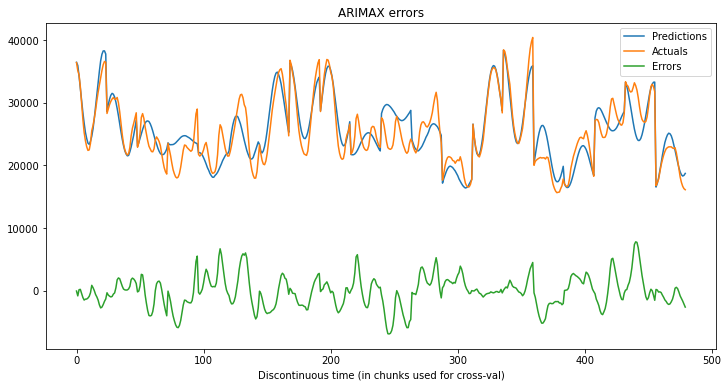

In [53]:
# Add errros
compare['Errors'] = compare['Actuals'] - compare['Predictions']
compare.plot(figsize=(12,6))
plt.title('ARIMAX errors')
plt.xlabel('Discontinuous time (in chunks used for cross-val)')

In [54]:
# Calculate MAPE
np.mean(np.abs(compare['Errors'])/compare['Actuals'])

0.07813559302193628

## View ARIMAX Fit of Complete Data Set

In [55]:
predict2 = res2.get_prediction(steps=24)
predicted_1day2 = predict2.predicted_mean
predicted_1day2.head()

2018-07-01 00:00:00     2408.196059
2018-07-01 01:00:00    51404.461592
2018-07-01 02:00:00    29741.294051
2018-07-01 03:00:00    31015.660623
2018-07-01 04:00:00    28605.387505
Freq: H, Name: predicted_mean, dtype: float64

In [56]:
sarimax_df2 = pd.merge(predicted_1day2, y, left_index=True, right_index=True)
sarimax_df2['1Day_Forecast_Error'] = sarimax_df2.iloc[:,-1]-sarimax_df2.iloc[:,-2]
sarimax_df2.head()

predicted_mean  Demand (MW)  1Day_Forecast_Error
2018-07-01 00:00:00     2408.196059        36142         33733.803941
2018-07-01 01:00:00    51404.461592        34552        -16852.461592
2018-07-01 02:00:00    29741.294051        33375          3633.705949
2018-07-01 03:00:00    31015.660623        31136           120.339377
2018-07-01 04:00:00    28605.387505        28683            77.612495

In [57]:
# Calculate overall MAPE
print('Sarimax model-fit error (full data set)')
np.mean(np.abs(sarimax_df2['1Day_Forecast_Error'])/sarimax_df2['Demand (MW)'])

Sarimax model-fit error (full data set)


0.012931781596813177

## Facebook Prophet Model

### Create df in Prophet format

In [59]:
# Create dataframe in format required by Facebook Prophet
proph_df = final_gen.iloc[:,[8]]
proph_df.reset_index(inplace=True)
proph_df.columns = ['ds','y']
proph_df.head()

ds      y
0 2021-06-01 04:00:00  19494
1 2021-06-01 03:00:00  21518
2 2021-06-01 02:00:00  23048
3 2021-06-01 01:00:00  23468
4 2021-06-01 00:00:00  23876

### Merge simulated weather forecasts

In [60]:
proph_df = pd.merge(proph_df, temperature_df['Sim_1Day_TempForecast'], left_on=proph_df['ds'], right_on=temperature_df.index)
proph_df.head()

key_0                  ds      y  Sim_1Day_TempForecast
0 2021-05-31 02:00:00 2021-05-31 02:00:00  20984                  59.70
1 2021-05-31 01:00:00 2021-05-31 01:00:00  20912                  59.70
2 2021-05-31 00:00:00 2021-05-31 00:00:00  21268                  59.70
3 2021-05-30 23:00:00 2021-05-30 23:00:00  21241                  55.08
4 2021-05-30 22:00:00 2021-05-30 22:00:00  21101                  55.33

### Fit model

In [61]:
# Fit model
m = Prophet()
m.fit(proph_df)

In [62]:
# Create datetimes for longterm prediction
future = m.make_future_dataframe(periods=365)

#Forecast
proph_forecast = m.predict(future)

In [63]:
proph_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower    yhat_upper
25918 2022-05-27 02:00:00  34042.698356  15453.023454  55943.513343
25919 2022-05-28 02:00:00  33472.803591  14316.527414  54981.240757
25920 2022-05-29 02:00:00  32372.430543  13431.731495  54701.067754
25921 2022-05-30 02:00:00  33161.379779  14131.715458  54219.222434
25922 2022-05-31 02:00:00  34507.571342  16070.679902  56791.310159

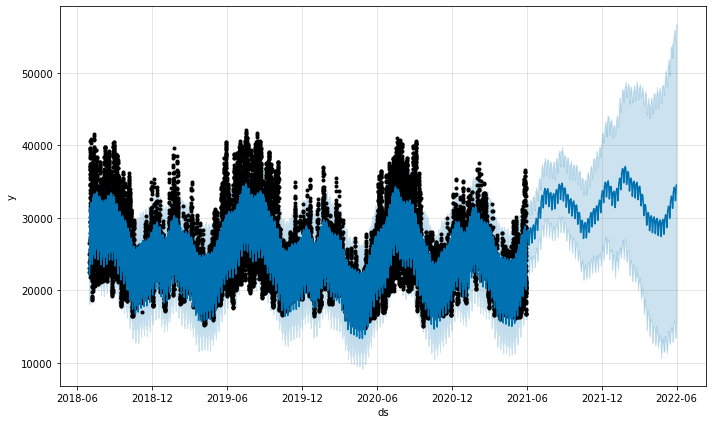

In [64]:
fig1=m.plot(proph_forecast)

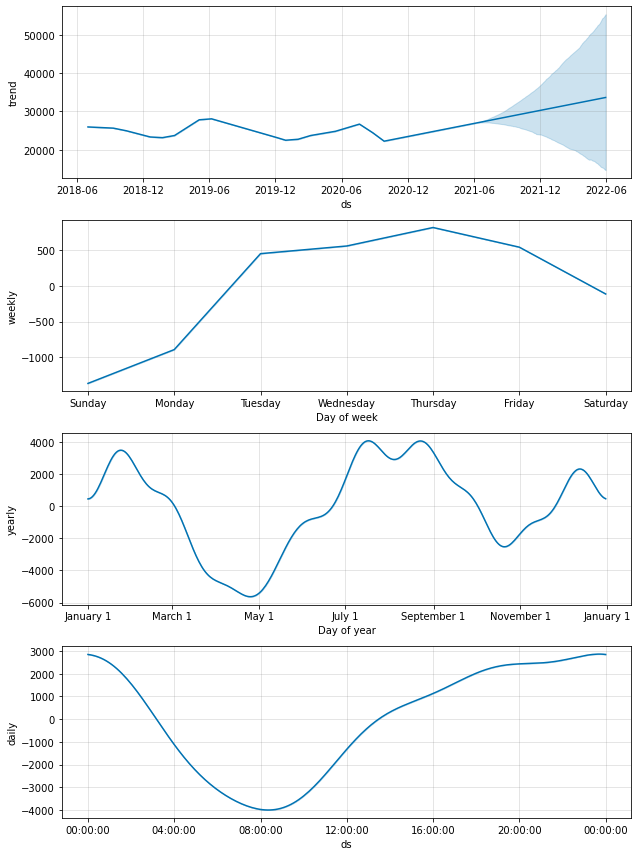

In [65]:
fig2 = m.plot_components(proph_forecast)

### Independent MAPE cross-validation of 24-hour Prophet Model

In [71]:
proph_df.head()

key_0                  ds      y  Sim_1Day_TempForecast
0 2021-05-31 02:00:00 2021-05-31 02:00:00  20984                  59.70
1 2021-05-31 01:00:00 2021-05-31 01:00:00  20912                  59.70
2 2021-05-31 00:00:00 2021-05-31 00:00:00  21268                  59.70
3 2021-05-30 23:00:00 2021-05-30 23:00:00  21241                  55.08
4 2021-05-30 22:00:00 2021-05-30 22:00:00  21101                  55.33

In [72]:
# Create a loop to test a 24 hour prediction for each time series split

tscv = TimeSeriesSplit(n_splits=5)

# Train-Test Split
X = proph_df['ds']
y = proph_df['y']

actuals = []
predictions = []

In [73]:
for train_index, test_index in tqdm(tscv.split(proph_df)):
    proph_train, proph_test = proph_df.iloc[train_index,:], proph_df.iloc[len(train_index):len(train_index)+24,:]

    # Instantiate and fit model
    m = Prophet()
    m.fit(proph_train)
    
    # Create datetimes for 24-hour forecast
    future = m.make_future_dataframe(periods=24)
    
    #Forecast
    forecast = m.predict(future)
    proph_1day = forecast['yhat'][-24:]
    
    # Get corresponding actual
    actual = y[len(proph_train):len(proph_train)+24]
    
    # Append to corresponding lists of actuals versus predictions
    actuals.append(actual)
    predictions.append(proph_1day)

0it [00:00, ?it/s]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
1it [00:08,  8.80s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2it [00:28, 15.11s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
3it [00:59, 22.56s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
5it [02:50, 34.06s/it]


In [74]:
# flatten lists
actuals = [item for sublist in actuals for item in sublist]
predictions = [item for sublist in predictions for item in sublist]

In [75]:
# Combine flattened lists into DataFrame
compare = pd.DataFrame({'Predictions': predictions, 'Actuals': actuals})
compare.head()

Predictions  Actuals
0  26856.142750    24205
1  27018.566082    23376
2  27101.676017    23224
3  26812.614830    23297
4  27195.985437    23479

Text(0, 0.5, 'MW')

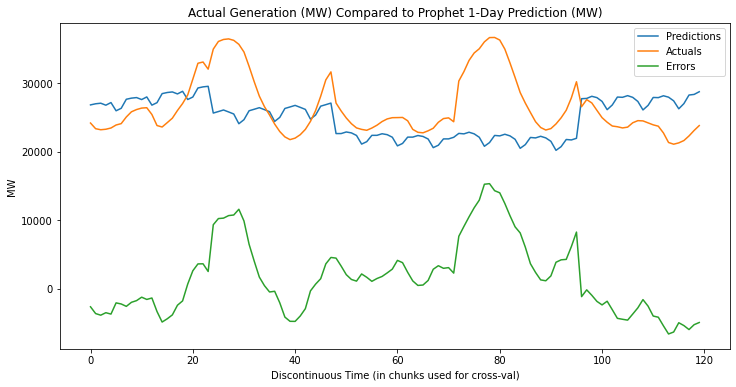

In [76]:
# Add errros
compare['Errors'] = compare['Actuals'] - compare['Predictions']


compare.plot(figsize=(12,6))
plt.title('Actual Generation (MW) Compared to Prophet 1-Day Prediction (MW)')
plt.xlabel('Discontinuous Time (in chunks used for cross-val)')
plt.ylabel('MW')

In [77]:
# Calculate MAPE
np.mean(np.abs(compare['Errors'])/compare['Actuals'])

0.15433839918945486

## Add Regressors to FB Prophet Model

In [78]:
proph_df = final_gen.iloc[:,[8]]
proph_df.reset_index(inplace=True)
proph_df.columns = ['ds','y']
proph_df.head()

ds      y
0 2021-06-01 04:00:00  19494
1 2021-06-01 03:00:00  21518
2 2021-06-01 02:00:00  23048
3 2021-06-01 01:00:00  23468
4 2021-06-01 00:00:00  23876

### Merge with Weather Data

In [79]:
temperature_df.head()

Columbia  Raleigh  Avg_Recorded  Sim_1Day_TempForecast
DATE                                                                       
2018-07-01 00:00:00      78.0     77.5         77.75                  80.51
2018-07-01 01:00:00      77.5     77.5         77.50                  80.26
2018-07-01 02:00:00      77.0     76.0         76.50                  79.26
2018-07-01 03:00:00      76.0     74.0         75.00                  77.76
2018-07-01 04:00:00      76.0     74.0         75.00                  77.76

In [80]:
proph_df = pd.merge(proph_df, temperature_df['Sim_1Day_TempForecast'], left_on=proph_df['ds'], right_on=temperature_df.index)
proph_df.head()

key_0                  ds      y  Sim_1Day_TempForecast
0 2021-05-31 02:00:00 2021-05-31 02:00:00  20984                  59.70
1 2021-05-31 01:00:00 2021-05-31 01:00:00  20912                  59.70
2 2021-05-31 00:00:00 2021-05-31 00:00:00  21268                  59.70
3 2021-05-30 23:00:00 2021-05-30 23:00:00  21241                  55.08
4 2021-05-30 22:00:00 2021-05-30 22:00:00  21101                  55.33

### Fit 24-hour forecasts to Prophet Model with Additional Regressor

In [81]:
# Create a loop to test a 24 hour prediction for each time series split

tscv = TimeSeriesSplit(n_splits=5)

actuals = []
predictions = []

In [82]:
m = Prophet()
m.add_regressor('Sim_1Day_TempForecast')
m.fit(proph_df)

In [83]:
for train_index, test_index in tqdm(tscv.split(proph_df)):
    proph_train, proph_test = proph_df.iloc[train_index,:], proph_df.iloc[len(train_index):len(train_index)+24,:]

    # Instantiate and fit model
    m = Prophet()
    m.add_regressor('Sim_1Day_TempForecast')
    m.fit(proph_df)
    
    # Create datetimes for 24-hour forecast
    future = m.make_future_dataframe(periods=24)
    # Merge in temperature data
    future = pd.merge(future, temperature_df['Sim_1Day_TempForecast'], left_on=future['ds'], right_on=temperature_df.index)
    
    #Forecast
    forecast = m.predict(future)
    proph_1day = forecast['yhat'][-24:]
    
    # Get corresponding actual
    actual = y[len(proph_train):len(proph_train)+24]
    
    # Append to corresponding lists of actuals versus predictions
    actuals.append(actual)
    predictions.append(proph_1day)

5it [09:35, 115.19s/it]


In [84]:
# flatten lists
actuals = [item for sublist in actuals for item in sublist]
predictions = [item for sublist in predictions for item in sublist]

In [85]:
# Combine flattened lists into DataFrame
compare = pd.DataFrame({'Predictions': predictions, 'Actuals': actuals})
compare.head()

Predictions  Actuals
0  25164.315493    24205
1  23808.810093    23376
2  22640.603785    23224
3  21824.819682    23297
4  21346.098761    23479

Text(0, 0.5, 'MW')

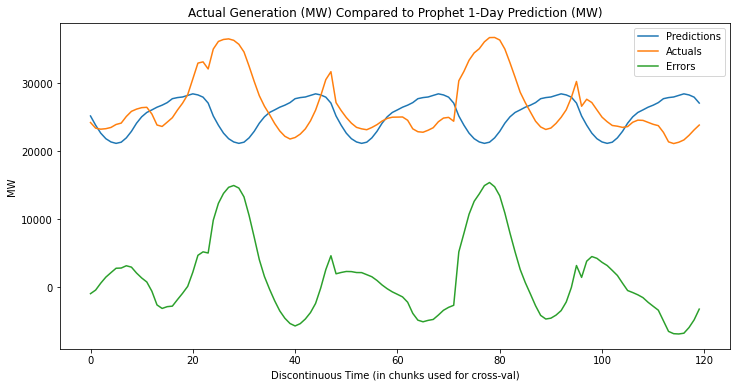

In [86]:
# Add errros
compare['Errors'] = compare['Actuals'] - compare['Predictions']


compare.plot(figsize=(12,6))
plt.title('Actual Generation (MW) Compared to Prophet 1-Day Prediction (MW)')
plt.xlabel('Discontinuous Time (in chunks used for cross-val)')
plt.ylabel('MW')

In [87]:
# Calculate MAPE
np.mean(np.abs(compare['Errors'])/compare['Actuals'])

0.15438714071500043

## EIA Day-Ahead Forecast Analysis

In [88]:
# Day-Ahead Demand Forecast Data

# Carolinas: http://api.eia.gov/category/?api_key=YOUR_API_KEY_HERE&category_id=3389853
# Midwest: http://api.eia.gov/series/?api_key=YOUR_API_KEY_HERE&series_id=EBA.MIDW-ALL.DF.HL

base_url = 'http://api.eia.gov/series/'
Carolinas_Demand = ['EBA.CAR-ALL.DF.HL']
Midwest_Demand = ['EBA.MIDW-ALL.DF.HL']

SERIES_ID = Carolinas_Demand

url = base_url + '/?api_key=' + eia_key + '&series_id=' + SERIES_ID[0]
r = requests.get(url)
json_data = r.json()
    
demand = pd.DataFrame(json_data.get('series')[0].get('data'), columns = ['Date', 'Day-Ahead Forecast (MW)'])
demand.set_index('Date', drop=True, inplace=True)

# Create date as datetype
demand['Year'] = demand.index.astype(str).str[:4]
demand['Month'] = demand.index.astype(str).str[4:6]
demand['Day'] = demand.index.astype(str).str[6:8]
demand['Hour'] = demand.index.astype(str).str[9:11]
demand['Date'] = pd.to_datetime(demand[['Year','Month','Day','Hour']])

demand.set_index('Date',drop=True,inplace=True)
final_demand = demand.iloc[:,:1]

In [89]:
final_demand.head()

Day-Ahead Forecast (MW)
Date                                        
2021-06-02 00:00:00                    22590
2021-06-01 23:00:00                    24583
2021-06-01 22:00:00                    26937
2021-06-01 21:00:00                    28066
2021-06-01 20:00:00                    29349

## Compare EIA Day-Ahead Forecast to Actual Electric Generation

"Each day, balancing authorities forecast hourly electricity demand on their systems for the next day. The forecast reflects daily, weekly, and seasonal demand patterns plus expected weather conditions."
https://www.eia.gov/beta/electricity/gridmonitor/about

In [90]:
# Merge generation data with demand data

# shift day-ahead forecast forward one-day to compare to the observed amount
demand_shifted = final_demand.shift(-5)

# merge on index data
df_all = final_gen.merge(demand_shifted, left_index=True, right_index=True, how='inner')

# add column describing difference between day-ahead forecast and actual
df_all['Excess Forecasted (MW)'] = df_all['Day-Ahead Forecast (MW)'] - df_all['Total_Generation (MW)']

forecast_errors = df_all.iloc[:,8:11]
forecast_errors.head()

Total_Generation (MW)  Day-Ahead Forecast (MW)  \
Date                                                                  
2018-07-01 05:00:00                  26539                  28353.0   
2018-07-01 06:00:00                  24971                  26132.0   
2018-07-01 07:00:00                  23889                  24225.0   
2018-07-01 08:00:00                  23048                  23036.0   
2018-07-01 09:00:00                  22493                  22171.0   

                     Excess Forecasted (MW)  
Date                                         
2018-07-01 05:00:00                  1814.0  
2018-07-01 06:00:00                  1161.0  
2018-07-01 07:00:00                   336.0  
2018-07-01 08:00:00                   -12.0  
2018-07-01 09:00:00                  -322.0

In [91]:
df_all.head()

Coal  Hydro  Natural Gas  Nuclear  Other  Petroleum  \
Date                                                                       
2018-07-01 05:00:00  6549   -356         7363    11616   1367          0   
2018-07-01 06:00:00  5984  -1063         7072    11614   1365          0   
2018-07-01 07:00:00  5606  -1751         7090    11616   1328          0   
2018-07-01 08:00:00  5278  -2005         6877    11614   1285          0   
2018-07-01 09:00:00  4955  -1961         6604    11614   1281          0   

                     Solar  Total_Renewables  Total_Generation (MW)  \
Date                                                                  
2018-07-01 05:00:00      0             11260                  26539   
2018-07-01 06:00:00     -1             10550                  24971   
2018-07-01 07:00:00      0              9865                  23889   
2018-07-01 08:00:00     -1              9608                  23048   
2018-07-01 09:00:00      0              9653                  22493   

                     Day-Ahead Forecast (MW)  Excess Forecasted (MW)  
Date                                                                  
2018-07-01 05:00:00                  28353.0                  1814.0  
2018-07-01 06:00:00                  26132.0                  1161.0  
2018-07-01 07:00:00                  24225.0                   336.0  
2018-07-01 08:00:00                  23036.0                   -12.0  
2018-07-01 09:00:00                  22171.0                  -322.0

<AxesSubplot:xlabel='Date'>

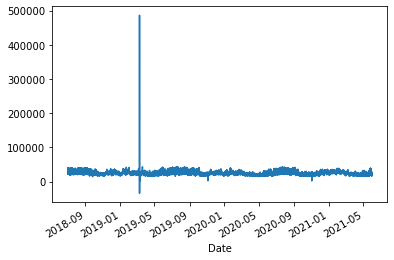

In [92]:
df_all['Day-Ahead Forecast (MW)'].plot()

### Filter out data errors

In [93]:
unfiltered = df_all[['Day-Ahead Forecast (MW)']]

# Create shifted dataframe to detect abrupt changes indicating data errors
shifted = unfiltered.shift(-1)

unfiltered.head()

Day-Ahead Forecast (MW)
Date                                        
2018-07-01 05:00:00                  28353.0
2018-07-01 06:00:00                  26132.0
2018-07-01 07:00:00                  24225.0
2018-07-01 08:00:00                  23036.0
2018-07-01 09:00:00                  22171.0

Text(0, 0.5, 'Frequency')

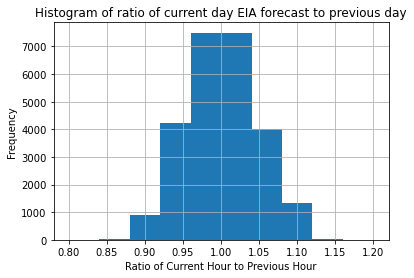

In [94]:
(unfiltered/shifted).hist(range=(0.8,1.2))
plt.title('Histogram of ratio of current day EIA forecast to previous day')
plt.xlabel('Ratio of Current Hour to Previous Hour')
plt.ylabel('Frequency')

In [95]:
# create Series of outlier values in EIA Day-Ahead forecast
out_of_range = (unfiltered.iloc[:,0] >= 1.15*shifted.iloc[:,0]) | (unfiltered.iloc[:,0] <= 0.85*shifted.iloc[:,0])
unfiltered[out_of_range].count()

Day-Ahead Forecast (MW)    50
dtype: int64

In [96]:
unfiltered[out_of_range].head()

Day-Ahead Forecast (MW)
Date                                        
2018-07-11 05:00:00                  28095.0
2018-09-26 05:00:00                  23891.0
2018-09-27 05:00:00                  17371.0
2018-11-04 04:00:00                  19417.0
2018-11-15 02:00:00                  28293.0

<AxesSubplot:xlabel='Date'>

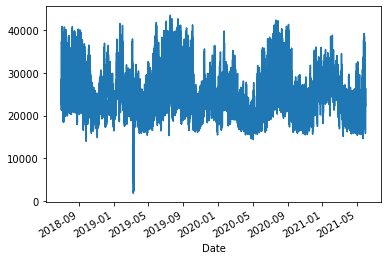

In [97]:
outlier_rmvd = unfiltered.iloc[:,0].where(~out_of_range, unfiltered.iloc[:,0].rolling(24).median())
df_all['Day-Ahead Forecast (MW)'] = outlier_rmvd
df_all['Day-Ahead Forecast (MW)'].plot()

In [98]:
# Recalculate forecast errors

df_all['Excess Forecasted (MW)'] = df_all['Day-Ahead Forecast (MW)'] - df_all['Total_Generation (MW)']
forecast_errors = df_all.iloc[:,8:11]

In [99]:
# Plot forecast errors

fig = go.Figure()

# Add traces
for i in range(len(forecast_errors.columns)):
    fig.add_trace(go.Scatter(x=forecast_errors.index, y=forecast_errors.iloc[:,i],
                    mode='lines',
                    name=forecast_errors.columns[i],
                    line_width=1))
    

# Label Graph
fig.update_layout(
    title="Error in Day-Ahead Forecast by Balancing Authorities",
    xaxis_title="Date",
    yaxis_title="Demand (MW)",
    legend_title="Legend Title",
    font=dict(
        family="Ariel",
        size=12,
        color="Black"
    )
)

fig.show()

In [100]:
forecast_errors.head()

Total_Generation (MW)  Day-Ahead Forecast (MW)  \
Date                                                                  
2018-07-01 05:00:00                  26539                  28353.0   
2018-07-01 06:00:00                  24971                  26132.0   
2018-07-01 07:00:00                  23889                  24225.0   
2018-07-01 08:00:00                  23048                  23036.0   
2018-07-01 09:00:00                  22493                  22171.0   

                     Excess Forecasted (MW)  
Date                                         
2018-07-01 05:00:00                  1814.0  
2018-07-01 06:00:00                  1161.0  
2018-07-01 07:00:00                   336.0  
2018-07-01 08:00:00                   -12.0  
2018-07-01 09:00:00                  -322.0

In [101]:
# Calculate MAPE
np.mean(np.abs(forecast_errors.iloc[:,2])/forecast_errors.iloc[:,1])

0.050873268064188834

### Requirements.txt for packages used in this notebook

In [105]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
